#            ***STUDY OF UNEMPLOYMENT RATE OVER GREECE, SLOVAKIA AND SPAIN***













# `Initial Preparation`

Import of all the libraries

In [37]:
!pip install pmdarima
from bs4 import BeautifulSoup
from matplotlib import pyplot
from pandas.core.api import isnull
from pmdarima import auto_arima
from scipy import stats
from scipy.stats import shapiro, anderson
from sklearn.datasets import make_classification,make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
cwd = os.getcwd()
#for everything to work properly, you need to add your google drive and add the data in the google drive

The First step of the project is to perform an EDA, Exploratory Data Analysis in order to select the relevant data, understand it and figure out the adaquate statistical tools required.
 
We will start with studying some variables that we think might influence the Unemployment Rate.





First we filtered the following datasets to retrieve countries in europe. And started the cleaning by deleted redudent elements. 

In [38]:
#The data contains redundant countries, for example Italy is present in the data twice in the country ITA and in OECD, so we need to remove them and only keep the countries
#In order to do that, we'll remove all the locations that are not countries such as OECDE or G-20 etc. to do that and to make future work easier, we import data that contains all the countries with country codes

# Download the file from GitHub
url = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
response = requests.get(url)      

# Save the file, called "ISO.csv" into the data folder 

# The Iso Dataset contains the countries and their Respective 3 Letter Code
with open('data/ISO.csv', 'w') as ISO:
  ISO.write(response.text)

# Read the file into a DataFrame
ISO = pd.read_csv('data/ISO.csv')
Countries = ISO[['name','alpha-3']]
Countries

,name,alpha-3
0,Afghanistan,AFG
1,Åland Islands,ALA
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM
...,...,...
244,Wallis and Futuna,WLF
245,Western Sahara,ESH
246,Yemen,YEM
247,Zambia,ZMB


In [39]:
#Import the list of EU countries 

res=requests.get('https://en.wikipedia.org/wiki/Member_state_of_the_European_Union')
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[2]
EU = pd.read_html(str(table))[0]

#Clean the data in order to be able to use them later as a filter
diz={}
for i in EU['Name']:
    diz[i]=i.split('[')[0] if i.split('[')[0] != "Czech Republic" else "Czechia"
EU['name']=EU['Name'].map(diz)
EU=EU[EU['Flag']!='Totals/Averages']

#Filter the Countries dataset and rename the columns
Countries=Countries.loc[Countries['name'].isin(EU['name'])]
Countries_miss=EU.loc[~EU['name'].isin(Countries['name'])]
Countries=Countries.rename(columns={'alpha-3':'ISO','name':'COU'}).reset_index().drop('index',axis=1)

#Check if all EU countries are in the Countries dataset and if Countries dataset contains only EU countries
if Countries['ISO'].count() != EU['name'].count():
  print('Problems with columns association'+ " Countries: "+str(Countries['ISO'].count()) + " EU: "+str(EU['name'].count()))

#Now,the Countries dataset contains only the europian countries
Countries


,COU,ISO
0,Austria,AUT
1,Belgium,BEL
2,Bulgaria,BGR
3,Croatia,HRV
4,Cyprus,CYP
5,Czechia,CZE
6,Denmark,DNK
7,Estonia,EST
8,Finland,FIN
9,France,FRA


Defining some functions that will be used later in the code

In [40]:
# Function to check the presence of missing countries in a dataset

def Missing_countries(Data,LOCATION='ISO'):
  Missing=Countries.loc[~Countries['ISO'].isin(Data[LOCATION])]['ISO']

  if Missing.count()>0:
    return list(Missing)
  else:
    return ''

In [41]:
#Function to check the presence of countries with no data

def Missing_countries_pivot(Data,VALUE,LOCATION='ISO'):
  Missing_countries=[]
  for i in Data[LOCATION].unique():
    if pd.isna(Data.loc[Data[LOCATION]==i][VALUE]).all():
      Missing_countries.append(i)
  
  if len(Missing_countries)>0:
    return Missing_countries
  else:
    return ''

In [42]:
#Function to create the Key-column based on the ISO of the country and the year of the observation

def KEY(data,var1='ISO',var2='TIME'):
  data.loc[:,'KEY']=data[var1]+'_'+ [str(x) for x in data[var2] ]


In [43]:
#Function to filter a column

def Flr(data,column_value):
  for i in column_value.keys():
    data=data[data[i]==column_value[i]]
  return data

In [44]:
#Function to group by variables and sum teh correspondies values
def group(data):
  return data.groupby(['ISO','TIME']).sum()

In [45]:
#Function to convert ISO to country name
def converter(ISOs):
  return Countries.loc[Countries['ISO'].isin (ISOs)]


# `Loading and Cleaning of the data`

## GDP Dataset

GDP and unemployment rate are two important economic indicators that are closely related.

Note about the cleaned dataset:


*   **Years range**: 1970-2021
*   **Type of data**: USD
*   **Source**: Kaggle




In [46]:
#Read the GDP Per Capita Data
GDP = pd.read_csv('data/GDP Per Capita.csv') 

#Rename some columns and filter the countries to keep only the EU ones
GDP=GDP.rename(columns={'LOCATION':'ISO','Value':'GDP$(pc)'})
GDP = GDP.loc[GDP['ISO'].isin(Countries['ISO'])] 

#Filter the columns
GDP=Flr(GDP,{'MEASURE':'USD_CAP','FREQUENCY':'A','SUBJECT':'TOT'})

#Drop the unecessary columns
GDP=GDP.drop(['MEASURE','FREQUENCY','SUBJECT','INDICATOR','Flag Codes'],axis=1)

#Create the key-column
KEY(GDP)

#Arrenge the dataset nicely
GDP=GDP.reindex(columns=['KEY','ISO','TIME','GDP$(pc)']).reset_index().drop('index',axis=1)
GDP.loc[:,'GDP$(pc)']=round(GDP['GDP$(pc)'],1)

#Check for any missing EU countries in the dataset
print(Missing_countries(GDP))

GDP

,KEY,ISO,TIME,GDP$(pc)
0,AUT_1970,AUT,1970,3827.5
1,AUT_1971,AUT,1971,4208.0
2,AUT_1972,AUT,1972,4635.8
3,AUT_1973,AUT,1973,5100.4
4,AUT_1974,AUT,1974,5768.7
...,...,...,...,...
1108,ROU_2017,ROU,2017,27136.1
1109,ROU_2018,ROU,2018,29338.1
1110,ROU_2019,ROU,2019,31860.3
1111,ROU_2020,ROU,2020,32182.1


In [47]:
#We pivot the data so it is easier to read as a time series
print(Missing_countries_pivot(GDP,'GDP$(pc)'))
GDP_Pivot = pd.pivot_table(data=GDP, index=['ISO'], columns='TIME', values='GDP$(pc)')
GDP_Pivot

TIME,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46477.7,47936.7,48813.5,49942.1,52665.1,54188.4,56956.1,58040.3,55938.9,58861.2
BEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42290.5,43672.7,44929.9,46201.7,48599.2,50442.9,52530.8,54324.4,53431.0,58352.9
BGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16327.9,16647.1,17616.9,18391.8,20074.4,21470.0,23016.0,24497.5,24564.3,26743.2
CYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31834.5,30375.3,30080.3,31815.2,35719.2,38288.1,40559.4,42338.7,39593.3,42540.6
CZE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29258.9,30828.5,32504.2,33909.3,36101.3,38842.9,41157.4,42865.7,41706.8,44197.9
DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43359.5,44993.7,47011.3,47609.6,50579.5,53071.5,55195.7,55651.4,55461.2,58385.8
DNK,NaN,NaN,NaN,NaN,NaN,NaN,3478.8,3688.3,4005.8,4487.2,...,44808.5,46742.9,47905.5,49058.1,51967.0,55356.5,57479.4,58495.6,60098.5,64876.7
ESP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31724.8,32463.1,33559.0,34945.5,37333.1,39601.5,40776.8,41759.4,37629.3,40831.3
EST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25946.9,27418.7,28917.8,29222.7,31310.2,33867.8,36488.6,37953.8,38546.8,43245.1


## Unemployment Rate Dataset

Note about the cleaned dataset:


*   **Range of years**: 1992-2020
*   **Type of data**: % of the population
*   **Source**: Kaggle



In [48]:
#Read "UNEMPLOYMENT.xlsx" file to get the Unemployment_rate dataset
Unemployment_rate=pd.read_excel('data/UNEMPLOYMENT.xlsx',sheet_name='DATA')

#Change the dataset layout, creating the variables TIME and UN_rate
Unemployment_rate=pd.melt(Unemployment_rate,id_vars='GEO (Labels)',var_name='TIME',value_name='UN_rate')

#Rename the columns to make the dataset reading easier
Unemployment_rate=Unemployment_rate.rename(columns={'GEO (Labels)':'COU'})

#Add the column ISO by merging the Unemployment_rate dataset with the Countries one 
Unemployment_rate=pd.merge(Unemployment_rate,Countries,on='COU',how='right')

#Reformat the dataset values and reindex the columns 
Unemployment_rate=Unemployment_rate.replace(':',np.nan).reindex(columns=['KEY','ISO','TIME','UN_rate'])

#Create the key-column
KEY(Unemployment_rate)


Unemployment_rate.loc[:,'UN_rate']=[float(x) if pd.isnull(x)==False else x for x in Unemployment_rate['UN_rate']]

#Check for any missing EU countries in the dataset
print(Missing_countries(Unemployment_rate,'ISO'))

Unemployment_rate

,KEY,ISO,TIME,UN_rate
0,AUT_1992,AUT,1992,NaN
1,AUT_1993,AUT,1993,NaN
2,AUT_1994,AUT,1994,NaN
3,AUT_1995,AUT,1995,2.7
4,AUT_1996,AUT,1996,2.9
...,...,...,...,...
778,SWE_2016,SWE,2016,5.0
779,SWE_2017,SWE,2017,4.9
780,SWE_2018,SWE,2018,4.6
781,SWE_2019,SWE,2019,5.0


In [49]:
#We pivot the data so it is easier to read as a time series
Unemployment_rate_pivot=pd.pivot_table(data=Unemployment_rate,index=['ISO'],columns='TIME',values='UN_rate')
print(Missing_countries_pivot(Unemployment_rate,'UN_rate','ISO'))
Unemployment_rate_pivot


TIME,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,NaN,NaN,2.7,2.9,2.9,2.8,2.4,2.2,2.3,2.5,...,3.0,3.2,3.6,3.8,3.8,4.1,3.7,3.3,3.1,3.6
BEL,4.6,5.2,5.2,5.2,5.1,5.2,4.9,4.0,3.7,4.3,...,4.2,4.5,5.1,5.1,5.1,4.7,4.2,3.6,3.2,3.3
BGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,11.1,9.8,...,6.5,7.2,7.7,6.9,5.5,4.5,3.8,3.2,2.7,3.2
CYP,NaN,NaN,NaN,NaN,3.1,3.1,3.3,3.1,2.6,2.4,...,5.3,8.0,10.7,11.0,10.0,8.6,7.4,5.7,4.9,5.2
CZE,NaN,NaN,NaN,NaN,NaN,4.2,5.7,5.7,5.2,4.7,...,4.2,4.4,4.5,3.9,3.3,2.6,1.9,1.5,1.3,1.7
DEU,4.9,5.4,5.2,5.7,6.2,6.0,5.5,5.0,5.0,5.5,...,3.9,3.6,3.6,3.4,3.2,2.9,2.6,2.4,2.2,2.7
DNK,7.5,5.9,5.1,4.8,4.1,3.8,4.0,3.3,3.3,3.3,...,5.4,5.3,5.0,4.7,4.2,4.1,4.0,3.5,3.5,3.9
ESP,12.1,13.0,12.3,12.0,11.3,10.3,8.8,8.0,6.0,6.7,...,14.2,16.5,17.3,16.0,14.5,12.8,11.2,9.9,9.1,9.9
EST,NaN,NaN,NaN,NaN,6.6,6.4,7.9,9.3,8.2,7.0,...,8.3,6.8,5.9,5.0,4.5,4.9,4.2,3.9,3.2,5.0


## Migration Dataset

Note about the cleaned dataset:


*   **Years range**: 2000-2020 (for some countries the renge is shorter)
*   **Type of data**: Absolute value
*   The observations are diveded in: immigrants (IN) and emigrants (OUT)
*   **Source**: Kaggle





In [50]:
#Read "Migrants.csv" file to get the Migrants dataset
Migrants= pd.read_csv('data/Migrants.csv')

#Filter the countries to keep only the EU ones
Migrants=Migrants.loc[Migrants['COU'].isin(Countries['ISO'])] 

#Filter the columns. We filter the columns GEN and Gender selecting the value "TOT" and "Total" becouse we are not interesting in differentiat the immgrants by sex
Migrants=Flr(Migrants,{'GEN':'TOT','Gender':'Total'})

#We filter the column 'Variable' since we are interesting only in 'Outflows of foreign population by nationality' and 'Inflows of foreign population by nationality' data.
Migrants = Migrants.loc[Migrants['Variable'].isin(['Outflows of foreign population by nationality','Inflows of foreign population by nationality'])]

#In order to semplify the analysis process the values of the column 'Variable' are renamed
Migrants.loc[Migrants['Variable']=='Outflows of foreign population by nationality','Variable']='OUT'
Migrants.loc[Migrants['Variable']=='Inflows of foreign population by nationality','Variable']='IN'

#Drop the unnecessary columns
Migrants=Migrants.drop(['GEN','Gender','Flag Codes','Flags','Country of birth/nationality','Country','VAR','YEA'],axis=1)

#Rename the columns to make the dataset comprehension easier
Migrants=Migrants.rename(columns={'COU':'ISO','Year':'TIME','Value':'MIG_num','Variable':'Direction'})

#Reorder the columns order 
Migrants=Migrants.reindex(columns=['KEY','ISO','TIME','Direction','MIG_num'])

#Create the key-column
KEY(Migrants)

#Check for any missing EU countries in the dataset
print("Missing countries: %s" %Missing_countries(Migrants,'ISO'))

Migrants

C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\2028203220.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  Migrants= pd.read_csv('data/Migrants.csv')


Missing countries: ['BGR', 'HRV', 'CYP', 'LTU', 'MLT', 'ROU']


,KEY,ISO,TIME,Direction,MIG_num
58,AUT_2000,AUT,2000,IN,828.0
59,AUT_2001,AUT,2001,IN,1539.0
60,AUT_2002,AUT,2002,IN,1101.0
61,AUT_2003,AUT,2003,IN,743.0
62,AUT_2004,AUT,2004,IN,650.0
...,...,...,...,...,...
437622,LVA_2017,LVA,2017,IN,20.0
437623,LVA_2018,LVA,2018,IN,38.0
437624,LVA_2019,LVA,2019,IN,25.0
437625,LVA_2020,LVA,2020,IN,14.0


As displayed, the dataset dosn't contain data for all EU countries. In particular, the dataset don't contain information about: Bulgaria, Croatia, Cyprus,Lithuania, Malta, Romania

Displaying the data of people entering the european countries. 

In [51]:
#Create a new dataset by filtering the main dataset for only incoming people
Inflow_migrants=Flr(Migrants,{'Direction':'IN'})
#Group the data for iso and time 
Inflow_migrants = group(Inflow_migrants)

Inflow_migrants

MIG_num
ISO TIME          
AUT 2000  131907.0
    2001  149572.0
    2002  172288.0
    2003  186682.0
    2004  208492.0
...            ...
SWE 2016  285785.0
    2017  249750.0
    2018  228640.0
    2019  196245.0
    2020  131431.0

[421 rows x 1 columns]

Displaying the data of people leaving the european countries. 

In [52]:
#Create a new dataset by filtering the main dataset for only incoming people
Outflow_migrants=Flr(Migrants,{'Direction':'OUT'})
#Group the data for iso and time 
Outflow_migrants = Inflow_Immigrants = group(Outflow_migrants)

Outflow_migrants

MIG_num
ISO TIME          
AUT 2000   88700.0
    2001  102008.0
    2002   88956.0
    2003   97879.0
    2004  100036.0
...            ...
SWE 2016   46892.0
    2017   46737.0
    2018   48174.0
    2019   50608.0
    2020   53460.0

[386 rows x 1 columns]

Creating a delta variable to capture the net migrants of european countries

In [53]:
Net_migrants=Migrants['MIG_num'].groupby([Migrants['KEY'],Migrants['ISO'],Migrants['TIME'],Migrants['Direction']]).sum().unstack('Direction')
Net_migrants.loc[:,'MIG_delta']=Net_migrants['IN']-Net_migrants['OUT']
Net_migrants=Net_migrants.drop(['IN','OUT'],axis=1)
Net_migrants

,,Direction,MIG_delta
KEY,ISO,TIME,
AUT_2000,AUT,2000,43207.0
AUT_2001,AUT,2001,47564.0
AUT_2002,AUT,2002,83332.0
AUT_2003,AUT,2003,88803.0
AUT_2004,AUT,2004,108456.0
...,...,...,...
SWE_2016,SWE,2016,238893.0
SWE_2017,SWE,2017,203013.0
SWE_2018,SWE,2018,180466.0


Displaying the variablity of the immigration rate over time.

In [54]:
#We pivot the data so it is easier to read as a time series
Inflow_migrants_Pivot = pd.pivot_table(data=Inflow_migrants, index=['ISO'], columns='TIME', values='MIG_num')
Inflow_migrants_Pivot

TIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,131907.0,149572.0,172288.0,186682.0,208492.0,195990.0,165798.0,183092.0,188736.0,181699.0,...,218733.0,250004.0,268858.0,306630.0,395310.0,316106.0,277446.0,262374.0,268800.0,241836.0
BEL,106731.0,121853.0,129526.0,127353.0,134359.0,144260.0,155111.0,173639.0,211965.0,205181.0,...,265264.0,231678.0,210665.0,211492.0,256926.0,211731.0,217894.0,238986.0,258349.0,202405.0
CZE,7787.0,21332.0,81746.0,114876.0,101597.0,117147.0,132247.0,205674.0,152046.0,76277.0,...,41317.0,57046.0,55649.0,76894.0,63123.0,69503.0,86910.0,111547.0,126431.0,107334.0
DEU,1245841.0,1300944.0,1316564.0,1203416.0,1203781.0,1158299.0,1102561.0,1133447.0,1139666.0,1204881.0,...,1674171.0,1920476.0,2201352.0,2657504.0,3975108.0,3415809.0,2745154.0,2745106.0,2668348.0,1973054.0
DNK,45104.0,48828.0,42703.0,36689.0,37281.0,40202.0,47893.0,62816.0,73937.0,63844.0,...,69079.0,70927.0,82592.0,97914.0,116063.0,108846.0,97680.0,90212.0,84352.0,75464.0
ESP,661732.0,788076.0,886133.0,858973.0,1291606.0,1365370.0,1605858.0,1840992.0,1134638.0,730631.0,...,671519.0,544671.0,496396.0,528628.0,579490.0,703710.0,907385.0,1119349.0,1328551.0,805654.0
EST,NaN,NaN,NaN,NaN,1473.0,1910.0,2934.0,3857.0,3858.0,4423.0,...,3309.0,2185.0,3230.0,2690.0,14737.0,14995.0,17703.0,18935.0,21947.0,15176.0
FIN,18220.0,22074.0,19944.0,18864.0,23022.0,25488.0,27736.0,35008.0,39812.0,36174.0,...,40832.0,46668.0,47746.0,47292.0,42821.0,54545.0,47466.0,46291.0,48287.0,46494.0
FRA,182904.0,213157.0,247927.0,272212.0,282506.0,271570.0,388052.0,291724.0,293284.0,298105.0,...,282667.0,301429.0,501034.0,489293.0,483207.0,489740.0,492841.0,515673.0,523130.0,406800.0


In [55]:
#We pivot the data so it is easier to read as a time series
Outflow_migrants_Pivot = pd.pivot_table(data=Outflow_migrants, index=['ISO'], columns='TIME', values='MIG_num')
Outflow_migrants_Pivot

TIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,88700.0,102008.0,88956.0,97879.0,100036.0,99600.0,110090.0,113286.0,120452.0,133631.0,...,145091.0,148259.0,148496.0,152519.0,159111.0,177313.0,178368.0,182751.0,179495.0,158350.0
BEL,64826.0,57799.0,56975.0,60591.0,67442.0,69013.0,70311.0,69262.0,86585.0,94780.0,...,104505.0,119500.0,137642.0,128635.0,118616.0,122951.0,116851.0,113318.0,92914.0,103373.0
CZE,301.0,38743.0,58850.0,66405.0,67565.0,43590.0,62772.0,36983.0,7645.0,18709.0,...,4921.0,33352.0,54238.0,32041.0,29995.0,26821.0,29005.0,32378.0,34800.0,53364.0
DEU,1092811.0,958986.0,1010904.0,997953.0,1093293.0,967316.0,933150.0,931641.0,1121101.0,1154283.0,...,1073308.0,1152343.0,1308848.0,1523059.0,1693948.0,2142737.0,1759503.0,1838719.0,1915351.0,1487220.0
DNK,27941.0,29559.0,29716.0,31467.0,31477.0,32543.0,34497.0,37966.0,46643.0,53170.0,...,53138.0,58187.0,59455.0,60831.0,61190.0,74692.0,83028.0,90604.0,104537.0,83381.0
ESP,NaN,NaN,13861.0,19938.0,83862.0,97425.0,240485.0,397915.0,509784.0,688203.0,...,706950.0,778539.0,917722.0,639823.0,498371.0,474890.0,563817.0,460354.0,439703.0,354246.0
EST,NaN,NaN,NaN,NaN,959.0,995.0,808.0,637.0,697.0,879.0,...,760.0,465.0,432.0,438.0,3967.0,5832.0,8190.0,7498.0,12439.0,8514.0
FIN,8256.0,4314.0,5514.0,4556.0,8372.0,5264.0,5426.0,6226.0,8992.0,8074.0,...,6668.0,8452.0,8470.0,10942.0,13354.0,14956.0,13612.0,15206.0,14454.0,13136.0
FRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23817.0,...,37908.0,40948.0,38370.0,49296.0,51923.0,50180.0,21547.0,30067.0,29910.0,21720.0


In [56]:
#We pivot the data so it is easier to read as a time series
Net_migrants_Pivot = pd.pivot_table(data=Net_migrants, index=['ISO'], columns='TIME', values='MIG_delta')
Net_migrants_Pivot

TIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,43207.0,47564.0,83332.0,88803.0,108456.0,96390.0,55708.0,69806.0,68284.0,48068.0,...,73642.0,101745.0,120362.0,154111.0,236199.0,138793.0,99078.0,79623.0,89305.0,83486.0
BEL,41905.0,64054.0,72551.0,66762.0,66917.0,75247.0,84800.0,104377.0,125380.0,110401.0,...,160759.0,112178.0,73023.0,82857.0,138310.0,88780.0,101043.0,125668.0,165435.0,99032.0
CZE,7486.0,-17411.0,22896.0,48471.0,34032.0,73557.0,69475.0,168691.0,144401.0,57568.0,...,36396.0,23694.0,1411.0,44853.0,33128.0,42682.0,57905.0,79169.0,91631.0,53970.0
DEU,153030.0,341958.0,305660.0,205463.0,110488.0,190983.0,169411.0,201806.0,18565.0,50598.0,...,600863.0,768133.0,892504.0,1134445.0,2281160.0,1273072.0,985651.0,906387.0,752997.0,485834.0
DNK,17163.0,19269.0,12987.0,5222.0,5804.0,7659.0,13396.0,24850.0,27294.0,10674.0,...,15941.0,12740.0,23137.0,37083.0,54873.0,34154.0,14652.0,-392.0,-20185.0,-7917.0
ESP,NaN,NaN,872272.0,839035.0,1207744.0,1267945.0,1365373.0,1443077.0,624854.0,42428.0,...,-35431.0,-233868.0,-421326.0,-111195.0,81119.0,228820.0,343568.0,658995.0,888848.0,451408.0
EST,NaN,NaN,NaN,NaN,514.0,915.0,2126.0,3220.0,3161.0,3544.0,...,2549.0,1720.0,2798.0,2252.0,10770.0,9163.0,9513.0,11437.0,9508.0,6662.0
FIN,9964.0,17760.0,14430.0,14308.0,14650.0,20224.0,22310.0,28782.0,30820.0,28100.0,...,34164.0,38216.0,39276.0,36350.0,29467.0,39589.0,33854.0,31085.0,33833.0,33358.0
FRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274288.0,...,244759.0,260481.0,462664.0,439997.0,431284.0,439560.0,471294.0,485606.0,493220.0,385080.0


## Minimum Wage Dataset






Note about the cleaned dataset:


*   **Years range**: 2001-2021
*   **Type of data**: Wage calculated on the base of purchasing power parity
*   **Source**: Kaggle


In [57]:
#Read "Minimum Wage.csv" file to get the Migrants dataset
Min_Wage = pd.read_csv('data/Minimum Wage.csv')

#Filter the countries to keep only the EU ones
Min_Wage = Min_Wage.loc[Min_Wage['COUNTRY'].isin(Countries['ISO'])] 

#Filter the data since we are only interested in the PPP values (Purchasing power parity) and annul observations
Min_Wage=Flr(Min_Wage,{'PERIOD':'A','SERIES':'PPP'})

#Remove the useless columns
Min_Wage=Min_Wage.drop(['Series','SERIES','Country','Time','PERIOD','Pay period','Unit','Unit Code','PowerCode','PowerCode Code','Reference Period Code','Flag Codes','Flags','Reference Period'],axis=1)

#Rename the columns to make the dataset comprehension easier
Min_Wage=Min_Wage.rename(columns={'COUNTRY':'ISO','Value':'Min_Wage(PPP)'})

#Create the key-column
KEY(Min_Wage)

#Reorder the columns
Min_Wage=Min_Wage.reindex(columns=['KEY','ISO','TIME','Min_Wage(PPP)'])

#Check for any missing EU countries in the dataset
print(Missing_countries(Min_Wage))

Min_Wage

['AUT', 'BGR', 'HRV', 'CYP', 'DNK', 'FIN', 'ITA', 'MLT', 'ROU', 'SWE']


,KEY,ISO,TIME,Min_Wage(PPP)
0,IRL_2001,IRL,2001,15713.18
1,IRL_2002,IRL,2002,15773.65
2,IRL_2003,IRL,2003,15944.71
3,IRL_2004,IRL,2004,17075.70
4,IRL_2005,IRL,2005,17822.01
...,...,...,...,...
2455,LVA_2017,LVA,2017,8678.07
2456,LVA_2018,LVA,2018,9577.19
2457,LVA_2019,LVA,2019,9315.30
2458,LVA_2020,LVA,2020,9294.94


As displayed the dataset dosn't contain data for all EU countries. In these case we can distinguish two categories. Countries whose data are simply missing: Bulgaria, Croatia, Malta, Romania. And countries whose don't have a minimum wage: Austria, Denmark, Italy, Cyprus, Finland, Sweden. 

In [58]:
#We pivot the data so it is easier to read as a time series
Min_Wage_Pivot = pd.pivot_table(data=Min_Wage, index=['ISO'], columns='TIME', values='Min_Wage(PPP)')
print(Missing_countries_pivot,'Min_Wage(PPP)')
Min_Wage_Pivot

<function Missing_countries_pivot at 0x0000019D019DA430> Min_Wage(PPP)


TIME,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ISO,,,,,,,,,,,,,,,,,,,,,
BEL,23941.45,24262.40,24122.04,23860.74,23678.63,23723.35,23997.18,23900.32,25084.54,24547.13,...,24226.11,24679.86,24596.23,24458.91,24225.92,24196.78,23944.89,24077.35,24139.55,23956.71
CZE,6224.49,6963.41,7565.25,7955.76,8376.11,8825.71,8843.42,8314.72,8230.81,8111.36,...,7705.44,7794.00,8043.28,8678.82,9275.76,10059.88,10922.55,11751.75,12319.83,12351.83
DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24171.43,24053.15,24781.51,24359.56,24889.37,24494.20,24531.00
ESP,12548.67,12421.24,12300.25,12183.50,12846.06,13374.08,13725.92,13867.98,14464.33,14420.35,...,13814.54,13705.49,13726.23,13865.80,14032.76,14869.11,15206.89,18468.72,19557.88,18971.08
EST,3551.65,3965.03,4568.35,5089.93,5304.48,5664.34,6376.40,6981.55,6987.03,6785.37,...,6486.73,6964.13,7734.04,8538.59,9400.37,9935.31,10218.34,10790.09,11721.38,11200.22
FRA,19173.32,19415.54,19748.91,20410.43,21198.76,21729.35,21949.37,21991.95,22376.91,22228.05,...,22486.36,22581.15,22705.22,22887.34,22988.09,22964.98,22824.89,22917.44,23081.64,22932.61
GRC,13839.25,14066.05,14282.41,14591.12,14874.43,15304.26,15672.17,15980.74,16694.59,16224.69,...,13060.24,12747.70,12917.21,13145.40,13254.84,13107.87,13026.18,14291.85,14592.73,14416.23
HUN,5781.02,6864.81,6559.09,6513.36,6764.03,7136.22,6927.42,6881.76,6842.90,6708.57,...,7730.48,8007.31,8312.21,8604.14,9060.04,10179.99,10700.41,11180.08,11691.54,11491.51
IRL,15713.18,15773.65,15944.71,17075.70,17822.01,17655.56,18657.45,18288.89,19146.28,19324.47,...,18528.35,18434.57,18400.98,18454.48,19519.59,19665.95,20205.09,20541.13,21241.01,20957.12


## Education Level Dataset

Notes about the dataset:


*   **Years range**: 2004-2021
*   **Type of data**: % of the population
*   Three educational levels based on ISCED11(International Standard    Classification of Education 2011)
*   **Source**: Kaggle




In [59]:
#Read "EDU_LEVEL.xlsx" file to get the Education level dataset
EDU_level=pd.read_excel('data/EDU_LEVEL.xlsx',sheet_name="DATA")

#Change the dataset layout, creating the variables TIME and EDU_rate
EDU_level=pd.melt(EDU_level, id_vars=['GEO (Labels)','ISCED11 (Labels)','ISCED11 (Codes)'],var_name="TIME",value_name="EDU_rate")

#Rename the columns to make the dataset reading easier
EDU_level=EDU_level.rename(columns={'GEO (Labels)':'COU','ISCED11 (Labels)':'ISCED11','ISCED11 (Codes)':'ISCED11_COD'})

#Add the column ISO by merging the Unemployment_rate dataset with the Countries one
EDU_level=pd.merge(EDU_level,Countries,on='COU',how='right')

#Create the key-column
KEY(EDU_level)

#Reindex the columns 
EDU_level=EDU_level.reindex(columns=['KEY','ISO','TIME','ISCED11_COD','ISCED11','EDU_rate'])

EDU_level.loc[:,'EDU_rate']=[float(x) if isnull(x)==False else x for x in EDU_level['EDU_rate']]

#Check for any missing EU countries in the dataset
print(Missing_countries(EDU_level,'ISO'))

EDU_level

,KEY,ISO,TIME,ISCED11_COD,ISCED11,EDU_rate
0,AUT_2004,AUT,2004,ED0-2,"Less than primary, primary and lower secondary...",27.5
1,AUT_2004,AUT,2004,ED3-8,"Upper secondary, post-secondary non-tertiary a...",72.5
2,AUT_2004,AUT,2004,ED3-4,Upper secondary and post-secondary non-tertiar...,57.3
3,AUT_2004,AUT,2004,ED5-8,Tertiary education (levels 5-8),15.2
4,AUT_2005,AUT,2005,ED0-2,"Less than primary, primary and lower secondary...",26.8
...,...,...,...,...,...,...
1868,SWE_2020,SWE,2020,ED5-8,Tertiary education (levels 5-8),37.6
1869,SWE_2021,SWE,2021,ED0-2,"Less than primary, primary and lower secondary...",20.8
1870,SWE_2021,SWE,2021,ED3-8,"Upper secondary, post-secondary non-tertiary a...",79.2
1871,SWE_2021,SWE,2021,ED3-4,Upper secondary and post-secondary non-tertiar...,40.2


In [60]:
#We pivot the data so it is easier to read as a time series
EDU_level_pivot=pd.pivot_table(data=EDU_level,index=['ISO','ISCED11_COD'],columns='TIME',values='EDU_rate')
print(Missing_countries_pivot,'EDU_rate')
EDU_level_pivot

<function Missing_countries_pivot at 0x0000019D019DA430> EDU_rate


TIME             2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  \
ISO ISCED11_COD                                                               
AUT ED0-2        27.5  26.8  27.3  27.6  26.5  25.5  24.8  24.7  24.0  23.5   
    ED3-4        57.3  58.7  58.4  58.3  58.9  58.8  59.4  59.5  59.6  59.4   
    ED3-8        72.5  73.2  72.7  72.4  73.5  74.5  75.2  75.3  76.0  76.5   
    ED5-8        15.2  14.5  14.3  14.1  14.6  15.6  15.9  15.9  16.4  17.1   
BEL ED0-2        42.4  40.2  39.4  38.2  36.8  35.8  35.7  34.9  34.4  33.4   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
SVN ED5-8        15.0  16.1  17.2  17.7  18.2  18.9  19.6  20.8  22.3  23.6   
SWE ED0-2        24.5  24.1  29.2  28.7  28.4  27.7  27.0  26.4  25.9  24.9   
    ED3-4        51.8  51.2  45.6  45.6  45.4  45.5  45.4  45.1  44.9  44.6   
    ED3-8        75.5  75.9  70.8  71.3  71.6  72.3  73.0  73.6  74.1  75.1   
    ED5-8        23.7  24.7  25.2  25.7  26.2  26.8  27.5  28.4  29.2  30.4   

TIME             2014  2015  2016  2017  2018  2019  2020  2021  
ISO ISCED11_COD                                                  
AUT ED0-2        21.7  20.9  20.6  20.5  20.0  19.8  19.7  19.4  
    ED3-4        52.2  52.3  51.6  51.2  51.1  50.5  50.5  50.2  
    ED3-8        78.3  79.1  79.4  79.5  80.0  80.2  80.3  80.6  
    ED5-8        26.1  26.9  27.8  28.3  28.8  29.8  29.8  30.4  
BEL ED0-2        32.4  31.5  30.7  29.7  28.7  28.1  27.3  25.0  
...               ...   ...   ...   ...   ...   ...   ...   ...  
SVN ED5-8        24.2  25.5  25.9  27.1  27.2  27.5  29.5  33.2  
SWE ED0-2        24.2  23.4  22.7  22.6  22.1  21.9  21.5  20.8  
    ED3-4        43.9  43.7  43.2  42.6  41.9  41.4  40.9  40.2  
    ED3-8        75.8  76.6  77.3  77.4  77.9  78.1  78.5  79.2  
    ED5-8        31.9  32.9  34.1  34.8  36.0  36.7  37.6  39.0  

[104 rows x 18 columns]

## Labour Cost Dataset

Notes about the dataset:


*  **Years range**: 2000-2021
*   **Type of data**: Index based on 2016 value
*   **Source**: Kaggle




In [61]:
#Read "LABOUR_COST_INDEX.xlsx" file to get the Labour_cost_index dataset
Labour_Cost_Index=pd.read_excel('data/LABOUR_COST_INDEX.xlsx',sheet_name="DATA")

#Change the dataset layout, creating the variables TIME and UN_rate
Labour_Cost_Index=pd.melt(Labour_Cost_Index, id_vars=['GEO (Labels)'],var_name="TIME",value_name="LCI(2016)")

#Rename the columns to make the dataset reading easier
Labour_Cost_Index=Labour_Cost_Index.rename(columns={'GEO (Labels)':'COU'})

#Add the column ISO by merging the Unemployment_rate dataset with the Countries one
Labour_Cost_Index=pd.merge(Labour_Cost_Index,Countries,on='COU',how='right')

#Create the key-column
KEY(Labour_Cost_Index)

#Reformat the dataset values and reindex the columns 
Labour_Cost_Index=Labour_Cost_Index.replace(':',np.nan).reindex(columns=['KEY','ISO','TIME','LCI(2016)'])


Labour_Cost_Index.loc[:,'LCI(2016)']=[float(x) if isnull(x)==False else x for x in Labour_Cost_Index['LCI(2016)']]

#Check for any missing EU countries in the dataset
print(Missing_countries(Labour_Cost_Index,'ISO'))

Labour_Cost_Index

,KEY,ISO,TIME,LCI(2016)
0,AUT_2000,AUT,2000,NaN
1,AUT_2001,AUT,2001,NaN
2,AUT_2002,AUT,2002,NaN
3,AUT_2003,AUT,2003,NaN
4,AUT_2004,AUT,2004,NaN
...,...,...,...,...
589,SWE_2017,SWE,2017,102.8
590,SWE_2018,SWE,2018,105.5
591,SWE_2019,SWE,2019,108.4
592,SWE_2020,SWE,2020,109.8


In [62]:
#We pivot the data so it is easier to read as a time series
Labour_Cost_Index_Pivot = pd.pivot_table(data=Labour_Cost_Index, index=['ISO'], columns='TIME', values='LCI(2016)')
print(Missing_countries_pivot,'LCI(2016)')
Labour_Cost_Index_Pivot

<function Missing_countries_pivot at 0x0000019D019DA430> LCI(2016)


TIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.1,...,90.9,93.6,96.3,99.1,100.0,103.4,107.1,109.1,116.2,117.2
BEL,69.0,71.4,74.0,75.5,77.5,79.3,81.2,83.0,85.9,89.1,...,97.0,99.0,99.7,99.8,100.0,101.2,102.8,104.9,106.5,107.7
BGR,27.6,30.0,31.7,34.2,36.2,38.2,40.5,47.5,59.5,66.0,...,78.4,82.6,87.9,93.8,100.0,112.2,120.8,134.9,145.4,159.1
CYP,68.8,72.6,76.8,82.0,85.3,88.6,92.8,96.1,101.9,109.0,...,108.6,106.1,102.6,100.9,100.0,102.5,105.8,111.3,110.6,117.1
CZE,43.6,49.8,54.5,60.4,63.4,66.7,71.1,76.6,81.1,83.7,...,89.7,90.1,92.3,96.0,100.0,108.1,117.2,126.9,134.7,141.1
DEU,73.9,75.8,77.6,79.4,79.7,80.0,81.1,81.8,83.6,85.8,...,92.3,93.1,95.4,97.8,100.0,103.1,106.0,109.1,112.2,113.8
DNK,NaN,66.7,69.1,71.7,74.4,76.7,78.9,81.7,84.8,88.1,...,93.9,94.9,96.4,98.1,100.0,102.0,104.0,106.3,108.4,111.8
ESP,64.7,67.6,71.1,75.0,78.2,81.1,83.8,87.6,91.3,95.9,...,97.6,98.4,98.8,99.6,100.0,100.5,101.8,104.6,109.3,109.2
EST,NaN,31.2,34.9,38.6,41.3,45.9,53.2,64.0,73.7,72.3,...,78.3,84.3,90.1,94.8,100.0,107.6,115.1,124.1,126.7,134.8


## Unemployment Expenditure Dataset

Notes about the cleaned dataset:


*  **Years range**: 2000-2020
*   **Type of data**: % of GDP
*   **Source**: Kaggle




In [63]:
#Read "SOCIAL_EXPEDITURE.xlsx" file to get the Unemployment_Expediture dataset
Unemployment_Expediture=pd.read_excel('data/SOCIAL_EXPEDITURE.xlsx',sheet_name="DATA")

#Change the dataset layout, creating the variables TIME and UN_rate
Unemployment_Expediture=pd.melt(Unemployment_Expediture, id_vars=['GEO (Labels)'],var_name="TIME",value_name="UN_EX(%GDP)")

#Rename the columns to make the dataset reading easier
Unemployment_Expediture=Unemployment_Expediture.rename(columns={'GEO (Labels)':'COU'})

#Add the column ISO by merging the Unemployment_rate dataset with the Countries one
Unemployment_Expediture=pd.merge(Unemployment_Expediture,Countries,on='COU',how='right')

#Reformat the dataset values and reindex the columns 
Unemployment_Expediture=Unemployment_Expediture.replace(':',np.nan).reindex(columns=['KEY','ISO','TIME','UN_EX(%GDP)'])

#Create the key-column
KEY(Unemployment_Expediture)

Unemployment_Expediture.loc[:,'UN_EX(%GDP)']=[float(x) if isnull(x)==False else x for x in Unemployment_Expediture['UN_EX(%GDP)']]

#Check for any missing EU countries in the dataset
print(Missing_countries(Unemployment_rate,'ISO'))

Unemployment_Expediture

,KEY,ISO,TIME,UN_EX(%GDP)
0,AUT_2000,AUT,2000,1.3
1,AUT_2001,AUT,2001,1.3
2,AUT_2002,AUT,2002,1.5
3,AUT_2003,AUT,2003,1.7
4,AUT_2004,AUT,2004,1.6
...,...,...,...,...
562,SWE_2016,SWE,2016,1.0
563,SWE_2017,SWE,2017,1.0
564,SWE_2018,SWE,2018,0.9
565,SWE_2019,SWE,2019,0.8


In [64]:
#We pivot the data so it is easier to read as a time series
Unemployment_Expediture_PIVOT=pd.pivot_table(data=Unemployment_Expediture, index=['ISO'], columns='TIME', values='UN_EX(%GDP)')
print(Missing_countries_pivot,'UN_EX(%GDP)')
Unemployment_Expediture_PIVOT

<function Missing_countries_pivot at 0x0000019D019DA430> UN_EX(%GDP)


TIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ISO,,,,,,,,,,,,,,,,,,,,,
AUT,1.3,1.3,1.5,1.7,1.6,1.6,1.5,1.4,1.3,1.6,...,1.5,1.5,1.6,1.6,1.6,1.7,1.7,1.6,1.5,3.7
BEL,2.9,2.9,3.1,3.4,3.4,3.3,3.3,3.2,3.2,3.7,...,3.6,3.4,3.4,3.4,3.0,2.5,1.9,1.8,1.5,2.8
BGR,NaN,NaN,NaN,NaN,NaN,0.3,0.3,0.3,0.3,0.5,...,0.5,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.7
CYP,1.0,0.9,0.8,0.8,0.9,1.0,1.1,0.8,0.9,0.9,...,1.6,2.2,2.6,1.8,1.4,1.3,1.0,1.0,0.9,3.7
CZE,0.6,0.6,0.6,0.7,0.7,0.6,0.5,0.6,0.6,1.0,...,0.7,0.6,0.6,0.6,0.5,0.5,0.5,0.4,0.4,0.9
DEU,2.1,2.0,2.2,2.3,2.2,2.0,1.8,1.5,1.4,1.8,...,1.3,1.1,1.1,1.1,1.0,1.0,1.0,0.9,0.9,1.7
DNK,2.9,2.8,2.6,2.9,2.7,2.5,2.0,1.4,1.1,1.8,...,2.0,2.0,1.9,1.7,1.6,1.5,1.4,1.3,1.3,1.4
ESP,1.9,2.0,2.1,2.1,2.1,2.1,2.1,2.0,2.3,3.6,...,3.6,3.5,3.3,2.7,2.2,1.9,1.7,1.7,1.7,3.6
EST,0.2,0.2,0.1,0.2,0.2,0.2,0.1,0.1,0.3,1.2,...,0.4,0.4,0.5,0.4,0.4,0.5,0.4,0.5,0.5,1.8


## Merge of the Data

In this section the previous datasets are merged together using the key-column. In this way a general dataset is created.

In [65]:
#Set the datasets that are going to be merged(with the exception of the EDU_level one)
variables=[GDP,Unemployment_rate,Net_migrants,Min_Wage,Labour_Cost_Index,Unemployment_Expediture]

#Creation of the final dataset with all the variables data

dataset=pd.DataFrame()

for i in range(1,len(variables)):
  if i==1:
    dataset=pd.merge(variables[i],variables[i-1],on="KEY",how="outer")
  else:
    dataset=pd.merge(dataset,variables[i],on="KEY",how="outer")

#The variable EDU_level has to be threat separetly becouse we need to create three variables for each education level
education_level=["ED0-2","ED3-4","ED5-8"]

for i in education_level:
  dataset=pd.merge(dataset,EDU_level.loc[EDU_level["ISCED11_COD"]==i],on="KEY",how="outer")
  dataset=dataset.rename(columns={"EDU_rate":"EDU_rate(%s)"%i})

#Delete the not interesting columns
erase=[]
for i in dataset.columns.values:
  if "ISO" in i or "TIME" in i or "ISCED11" in i:
    erase.append(i)

dataset=dataset.drop(erase,axis=1)

#Create the ISO and TIME columns
for i in dataset["KEY"]:
  dataset.loc[:,"ISO"]=[i.split("_")[0] for i in dataset["KEY"]]
  dataset.loc[:,"TIME"]=[int(i.split("_")[1]) for i in dataset["KEY"]]

#Order the data by time and rename the columns to make the dataset reading easier
dataset=dataset.sort_values(by="TIME").rename(columns={"UN_rate":"Unemployment_rate","GDP$(pc)":"GDP_pc", "MIG_delta":"Net_migration","Min_Wage(PPP)":"Min_Wage","LCI(2016)":"Labour_cost","UN_EX(%GDP)":"Unemployment_Expediture","EDU_rate(ED0-2)":"Education_rate_ED_0_2","EDU_rate(ED3-4)":"Education_rate_ED_3_4","EDU_rate(ED5-8)":"Education_rate_ED_5_8"})

dataset

C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\1213061446.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ISO_x', 'TIME_x'} in the result is deprecated and will raise a MergeError in a future version.
  dataset=pd.merge(dataset,variables[i],on="KEY",how="outer")
C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\1213061446.py:18: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ISO_x', 'TIME_x'} in the result is deprecated and will raise a MergeError in a future version.
  dataset=pd.merge(dataset,EDU_level.loc[EDU_level["ISCED11_COD"]==i],on="KEY",how="outer")
C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\1213061446.py:18: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ISO_x', 'TIME_x'} in the result is deprecated and will raise a MergeError in a future version.
  dataset=pd.merge(dataset,EDU_level.loc[EDU_level["ISCED11_COD"]==i],on="KEY",how="outer")


,KEY,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8,ISO,TIME
882,FRA_1960,NaN,1807.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA,1960
883,FRA_1961,NaN,1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA,1961
884,FRA_1962,NaN,2036.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA,1962
885,FRA_1963,NaN,2139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA,1963
886,FRA_1964,NaN,2294.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA,1964
...,...,...,...,...,...,...,...,...,...,...,...,...
1055,NLD_2021,NaN,63445.1,NaN,26205.87,111.2,NaN,26.0,38.2,35.8,NLD,2021
1058,POL_2021,NaN,37425.4,NaN,17048.88,138.4,NaN,13.8,59.3,26.8,POL,2021
1081,PRT_2021,NaN,36456.9,NaN,14411.59,117.2,NaN,46.1,27.9,26.0,PRT,2021
1105,ESP_2021,NaN,40831.3,NaN,18971.08,109.2,NaN,41.4,24.2,34.4,ESP,2021


According the table above, there are unemeployment rate data for all countries only from 2003 to 2020. Since the goal of this reaserch is to study te unemployment rate we have decide to filter the data.

In [66]:
#Filter the dataset in order to have data only fromt the period 2003-2020
dataset=dataset.loc[dataset['TIME'].isin(range(2003,2021))]
dataset

,KEY,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8,ISO,TIME
11,AUT_2003,2.8,32156.8,88803.0,NaN,NaN,1.7,NaN,NaN,NaN,AUT,2003
475,LTU_2003,7.8,12067.7,NaN,4897.33,41.1,0.3,NaN,NaN,NaN,LTU,2003
98,HRV_2003,7.7,13675.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HRV,2003
214,EST_2003,6.6,13089.8,NaN,4568.35,38.6,0.2,NaN,NaN,NaN,EST,2003
765,SWE_2003,4.0,31815.0,65708.0,NaN,NaN,1.7,NaN,NaN,NaN,SWE,2003
...,...,...,...,...,...,...,...,...,...,...,...,...
376,HUN_2020,2.7,33367.5,-8501.0,11691.54,142.0,0.5,20.2,56.7,23.1,HUN,2020
608,POL_2020,1.9,34040.7,268824.0,16631.37,128.0,0.7,13.9,59.3,26.7,POL,2020
463,LVA_2020,5.7,32311.0,1551.0,9294.94,136.7,1.0,14.2,53.3,32.4,LVA,2020
347,GRC_2020,9.6,27967.3,19049.0,14592.73,110.0,1.4,29.1,44.1,26.8,GRC,2020


# ANALYSIS

We displayed all the european coountries selected and their characteristics.  
To identify each country we used the Alpha-3 code which is three-letter country codes defined in ISO 

In [67]:
#Create a new dataset from the wikipedia one
EU_table=EU.drop(['Flag','Accession','Currency','Gini[5]','HDI[6]','MEPs','Languages','Name'],axis=1).rename(
    columns={'Area (km²)':'Area(km²)','Population[2]':'Population','GDP (PPP)per cap.[3][4]':'GDP per cap.','name':'COU'}).reindex(columns
    =['COU','Capital','Population','Area(km²)','GDP(US$ M)','GDP per cap.'])

#Cleane the data to display them
for i in EU_table.columns.tolist():
  EU_table.loc[:,i]=[str(x).split('[')[0] for x in EU_table.loc[:,i]]

EU_table

,COU,Capital,Population,Area(km²),GDP(US$ M),GDP per cap.
0,Austria,Vienna,8926000,83855,447718,55406
1,Belgium,Brussels,11566041,30528,517609,50114
2,Bulgaria,Sofia,6916548,110994,66250,23741
3,Croatia,Zagreb,4036355,56594,60702,27681
4,Cyprus,Nicosia,896000,9251,24280,39079
5,Czechia,Prague,10574153,78866,246953,40293
6,Denmark,Copenhagen,5833883,43075,347176,57781
7,Estonia,Tallinn,1330068,45227,31038,37033
8,Finland,Helsinki,5527493,338424,269654,49334
9,France,Paris,67439614,"632,833",2707074,45454


We plotted the variation of the unemployement through different points in time.

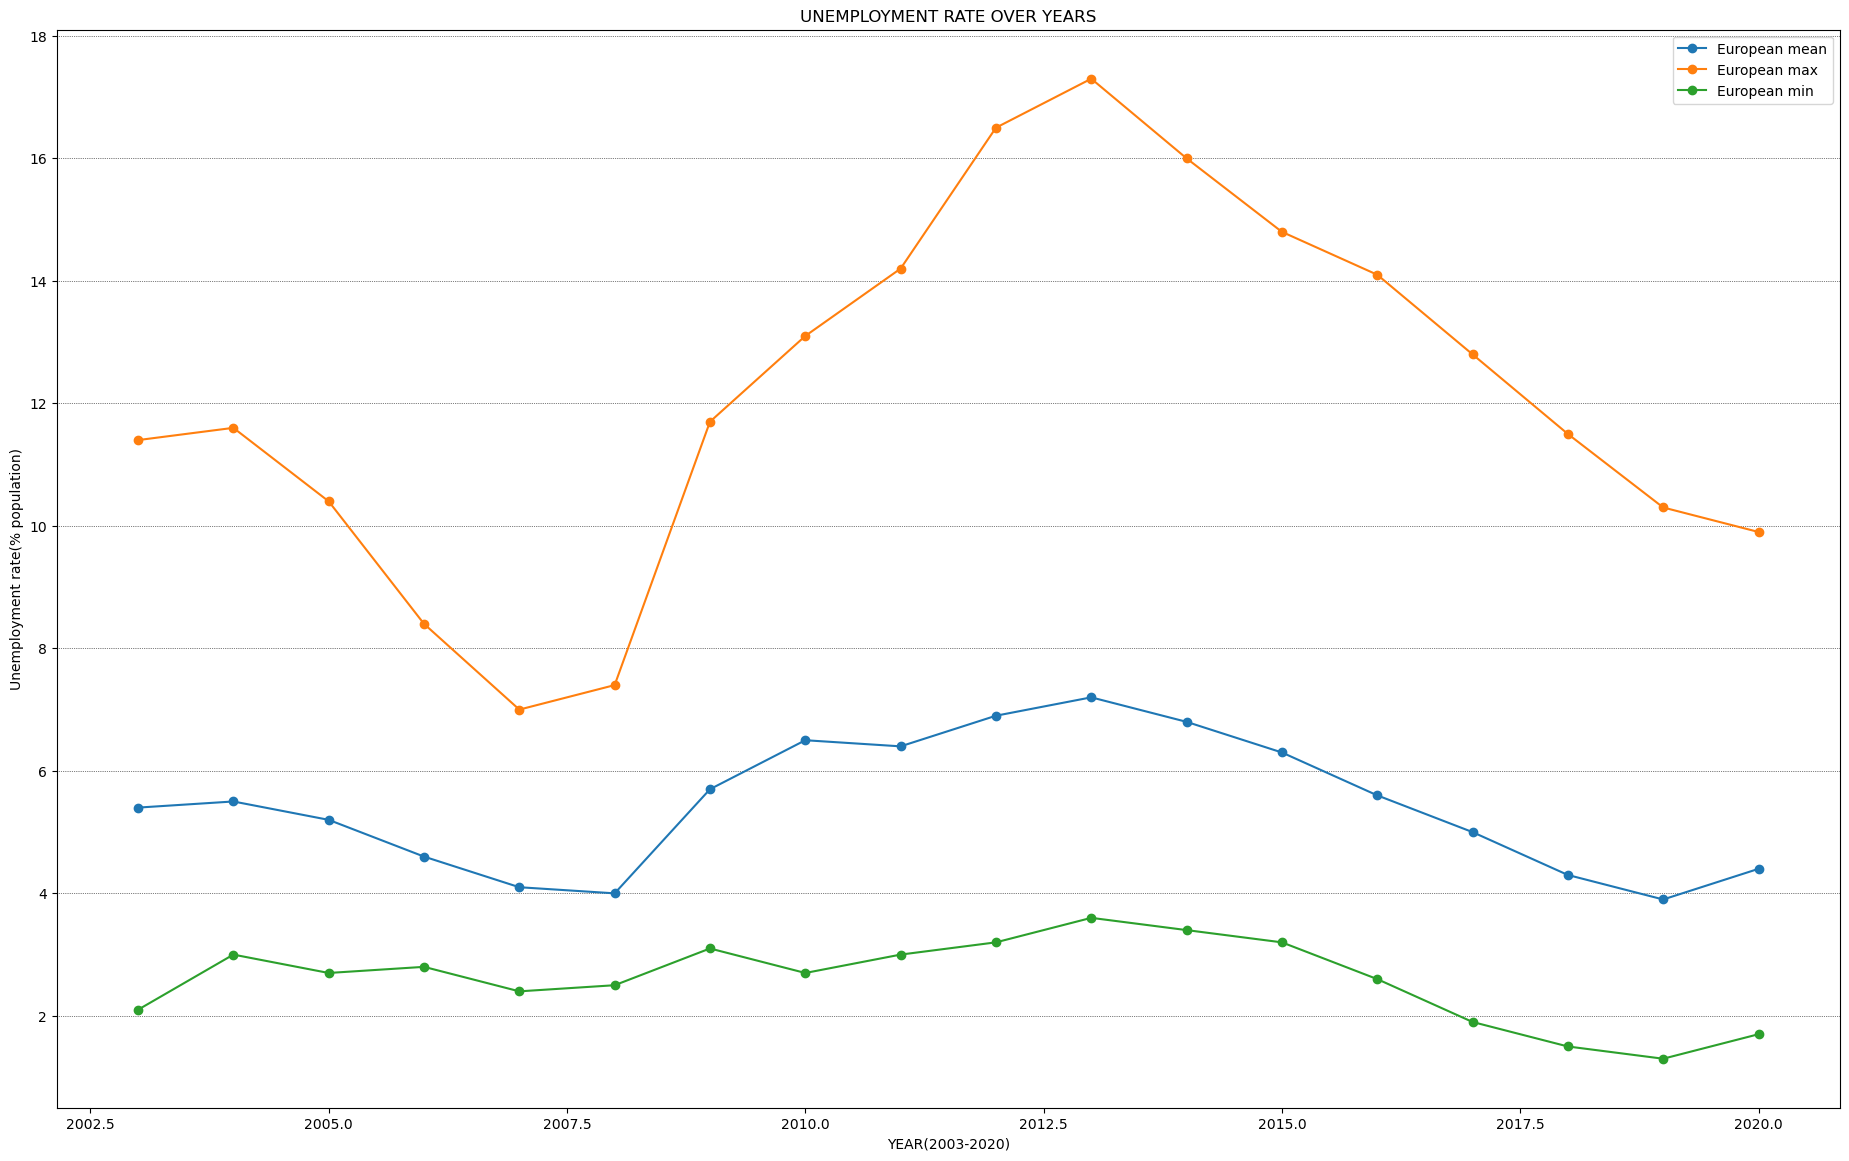

In [68]:
#Creation of three new datasets to study undemployment rate characteristics
Unemployment_rate_study=dataset.loc[:,['TIME','Unemployment_rate']]
Unemployment_rate_studymean=Unemployment_rate_study.groupby(['TIME']).mean().rename(columns={'Unemployment_rate':'Unemployment_rate(mean)'}).reset_index()
Unemployment_rate_studymax=Unemployment_rate_study.groupby(['TIME']).max().rename(columns={'Unemployment_rate':'Unemployment_rate(max)'}).reset_index()
Unemployment_rate_studymin=Unemployment_rate_study.groupby(['TIME']).min().rename(columns={'Unemployment_rate':'Unemployment_rate(min)'}).reset_index()

#Creation of the plot
fig=pyplot.figure(figsize=(23,14))

Rate_year_plot=fig.add_subplot()

Rate_year_plot.plot(Unemployment_rate_studymean['TIME'],round(Unemployment_rate_studymean['Unemployment_rate(mean)'],1),label='European mean',marker='o')
Rate_year_plot.plot(Unemployment_rate_studymax['TIME'],Unemployment_rate_studymax['Unemployment_rate(max)'],label='European max',marker='o')
Rate_year_plot.plot(Unemployment_rate_studymin['TIME'],Unemployment_rate_studymin['Unemployment_rate(min)'],label='European min',marker='o')
Rate_year_plot.set(xlabel="YEAR(2003-2020)",ylabel='Unemployment rate(% population)',title='UNEMPLOYMENT RATE OVER YEARS')
Rate_year_plot.legend()
Rate_year_plot.grid(axis="y",linewidth=0.5,color='k',linestyle='dotted')




The graph above shows fluctuations in the unemployment rate through the years. 
Our goal in this research is to identify the potential variables causing these fluctuations.

An anlaysis of the undmployment rate variation over the years and over the entire range of time is made 

In [69]:
#Create the dataset with unemployment rate variation over each years and over all the selected years
columns_name=[columns for columns in Unemployment_rate_pivot if int(columns)>=2003]
delta_rate=pd.DataFrame()
for i in range(1,len(columns_name)):
  delta_rate.loc[:,columns_name[i]]=Unemployment_rate_pivot[columns_name[i]]-Unemployment_rate_pivot[columns_name[i-1]]
delta_rate.loc[:,"Delta 2003-2020"]=(Unemployment_rate_pivot['2020']-Unemployment_rate_pivot['2003'])
delta_rate=delta_rate.reset_index()
delta_rate

,ISO,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Delta 2003-2020
0,AUT,0.7,0.1,-0.2,-0.2,-0.5,0.8,-0.3,-0.2,0.2,0.4,0.2,0.0,0.3,-0.4,-0.4,-0.2,0.5,0.8
1,BEL,0.2,0.1,-0.1,-0.4,-0.3,0.5,0.3,-0.8,0.3,0.6,0.0,0.0,-0.4,-0.5,-0.6,-0.4,0.1,-1.4
2,BGR,-0.8,-1.0,-0.5,-1.0,-0.7,0.7,2.0,0.5,0.7,0.5,-0.8,-1.4,-1.0,-0.7,-0.6,-0.5,0.5,-4.1
3,CYP,0.3,0.5,-0.5,-0.4,-0.2,1.1,0.7,1.0,2.7,2.7,0.3,-1.0,-1.4,-1.2,-1.7,-0.8,0.3,2.4
4,CZE,0.3,-0.2,-0.5,-1.2,-0.6,1.4,0.4,-0.4,0.2,0.1,-0.6,-0.6,-0.7,-0.7,-0.4,-0.2,0.4,-3.3
5,DEU,0.6,0.4,-0.6,-1.0,-0.7,0.2,-0.5,-0.7,-0.3,0.0,-0.2,-0.2,-0.3,-0.3,-0.2,-0.2,0.5,-3.5
6,DNK,0.1,-0.5,-0.7,-0.1,-0.1,1.9,0.9,0.0,-0.1,-0.3,-0.3,-0.5,-0.1,-0.1,-0.5,0.0,0.4,0.0
7,ESP,-0.2,-1.0,-0.3,-0.1,2.1,4.3,1.4,1.1,2.3,0.8,-1.3,-1.5,-1.7,-1.6,-1.3,-0.8,0.8,3.0
8,EST,-0.1,-1.4,-1.2,-0.9,0.7,5.3,2.1,-2.8,-1.5,-0.9,-0.9,-0.5,0.4,-0.7,-0.3,-0.7,1.8,-1.6
9,FIN,-0.2,-0.2,-0.4,-0.6,-0.3,1.2,0.1,-0.4,-0.1,0.3,0.3,0.5,-0.4,-0.1,-0.8,-0.4,0.7,-0.8


In order to have a better view of the countries whose undemployment rate changes more from 2003 to 2020, we decide to rappresent this data in a bar plot

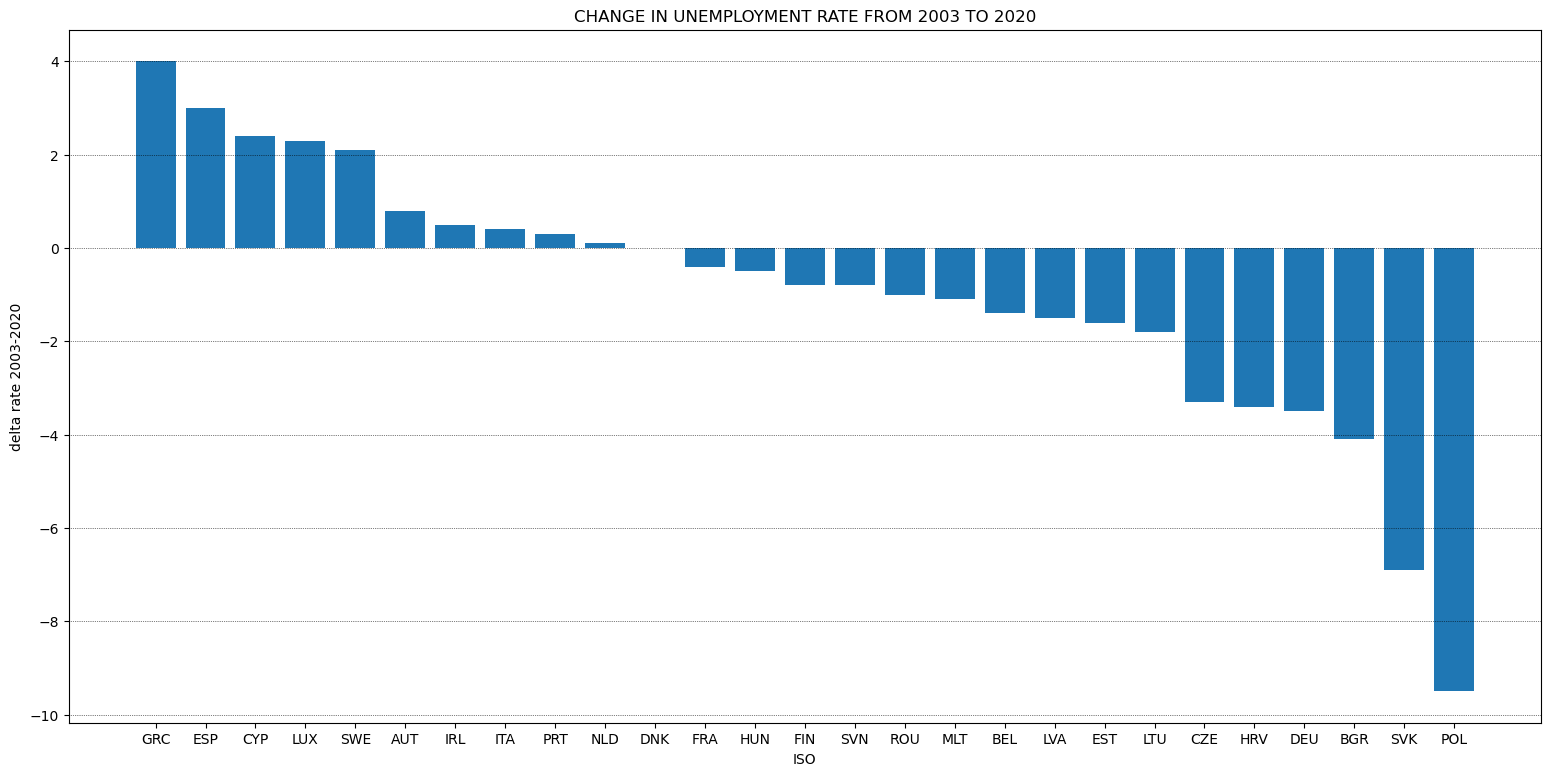

In [70]:
#Create the barplot
delta_rate=delta_rate.sort_values(by=["Delta 2003-2020"],ascending=False)
fig=pyplot.figure(figsize=(19,9))
Unemployment_deltarate_plot=fig.add_subplot()
Unemployment_deltarate_plot.grid(axis='y',linewidth=0.5,color='k',linestyle='dotted')
Unemployment_deltarate_plot.bar(delta_rate['ISO'],delta_rate["Delta 2003-2020"])
Unemployment_deltarate_plot.set(xlabel="ISO",ylabel="delta rate 2003-2020",title="CHANGE IN UNEMPLOYMENT RATE FROM 2003 TO 2020")
pyplot.show()

From the table and the plot above we notice that some countries have significant change in their unemployment rate while others not, we deicide to use this as our criteria to select the countries to analyse.
In particular we have decided to pick up the threee countries with the highest unemployment rate fluctuation over the selected years.

In order to achive this goal we have plotted the unemployment rate and the countries in a barplot.

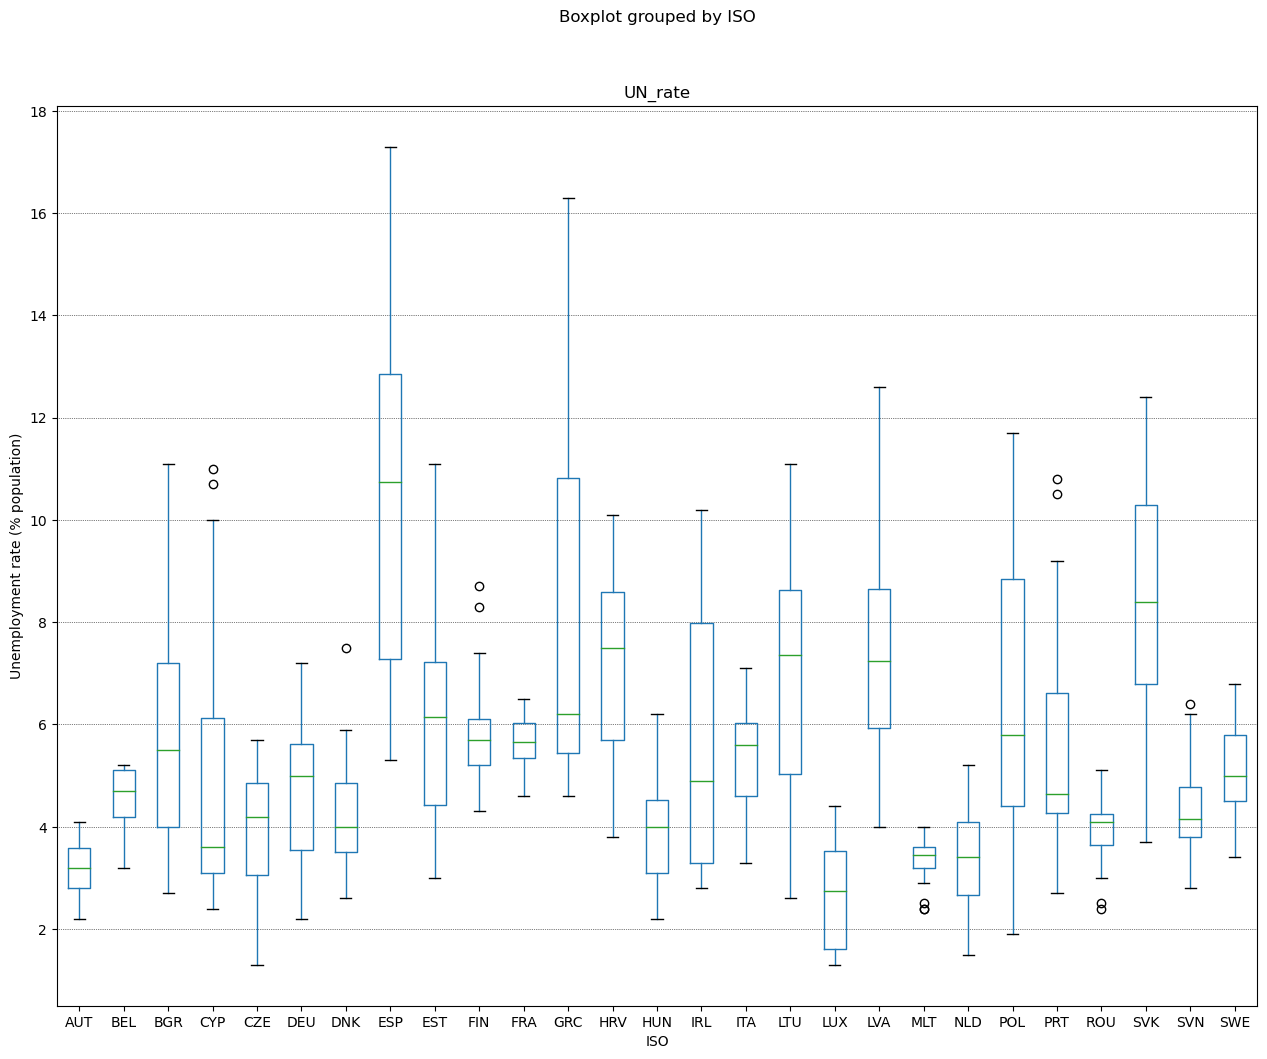

In [71]:
#Create the boxplot
fig, ax = plt.subplots(figsize=(15, 12), dpi=100)
Unemployment_rate.boxplot(by='ISO', column='UN_rate', grid=False,ax=ax)
ax.set(ylabel='Unemployment rate (% population)')
ax.grid(axis='y',linewidth=0.5,color='k',linestyle='dotted')

According to the above barplot the countries with the highest fluctuations are: Spain,Greece and Poland. However for the last one there haven't been enought data to do a proper analysis. So we have decided to add also the available data factor in our selection criteria. 

With this change our three countries are: GREECE, SPAIN, SLOVAKIA. 

The change of their unemployment rate over teh years is shown below

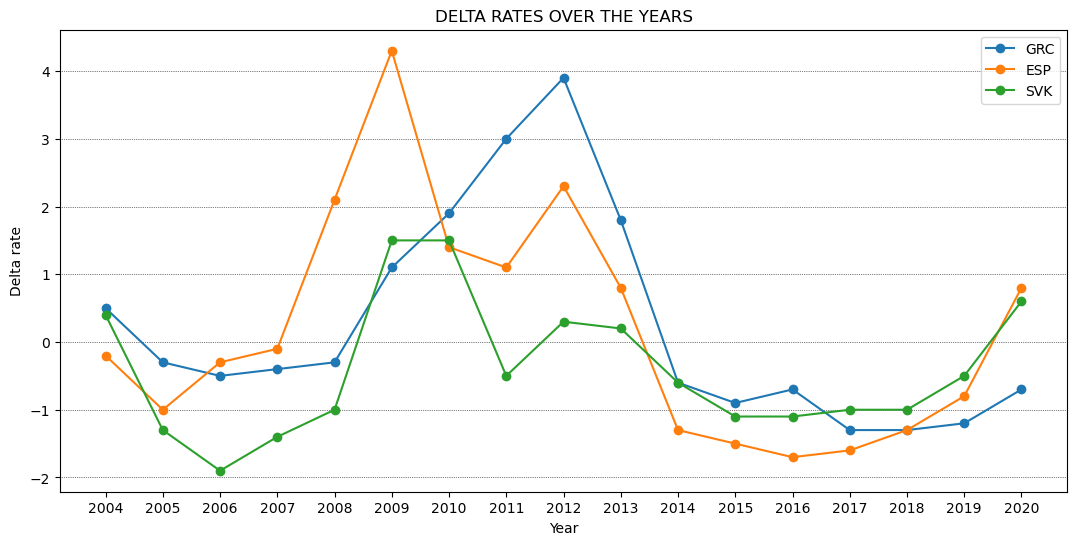

In [72]:
#Create a dataset with only the selected countries
List_selected_countries=["GRC","ESP","SVK"]
Selected_countries=delta_rate.loc[delta_rate['ISO'].isin(List_selected_countries),delta_rate.columns!="Delta 2003-2020"].reset_index().drop('index',axis=1)
Selected_countries=pd.melt(Selected_countries,id_vars=['ISO'],var_name="TIME",value_name='RATE')

#Create a plot of the unemployment rate change over the years for only the selected countries
fig=pyplot.figure(figsize=(13,6))
Selected_countries_plot=fig.add_subplot()
for i in Selected_countries['ISO'].unique():
  Selected_countries_plot.plot(Selected_countries.loc[Selected_countries['ISO']==i,'TIME'],Selected_countries.loc[Selected_countries['ISO']==i,'RATE'],marker="o",label=i)

Selected_countries_plot.legend()
Selected_countries_plot.set(xlabel="Year",ylabel="Delta rate",title="DELTA RATES OVER THE YEARS")
Selected_countries_plot.grid(axis="y",linewidth=0.5,color='k',linestyle='dotted')


To make teh study of each country easier, we decid to create a dataset for each one. The general characteristics are:


*   Years range: 2003-2020
*   Unemployment rate data available for each year
*   Very few missing data for the other variables

In [73]:
#Function to create the dataset for each selected countries
def countriesdata(data,ISO):
  result=data.loc[data['ISO']==ISO].drop(["KEY","ISO"],axis=1).set_index('TIME')
  return result

##Slovakia dataset

In [74]:
Slovakia_Data=countriesdata(dataset,"SVK")

Slovakia_Data

,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,,,,
2003,11.2,14165.4,1884.0,5401.44,53.9,1.0,NaN,NaN,NaN
2004,11.6,15197.8,5810.0,5452.06,56.8,1.0,24.0,66.0,10.0
2005,10.3,16595.3,13137.0,5664.43,62.0,0.5,22.5,66.5,11.0
2006,8.4,18851.4,7884.0,5811.54,66.9,0.5,21.2,67.2,11.6
2007,7.0,21136.1,13649.0,6175.23,71.8,0.5,20.6,67.9,11.5
2008,6.0,23609.0,14093.0,6190.36,75.5,0.6,19.5,68.5,12.0
2009,7.5,22947.0,8469.0,6695.32,78.6,1.0,18.3,68.6,13.1
2010,9.0,25222.7,6907.0,6905.65,80.7,1.0,17.9,67.5,14.6
2011,8.5,26260.2,6702.0,6846.06,83.5,0.8,17.2,67.0,15.8


##Spain dataset

In [75]:
Spain_Data=countriesdata(dataset,"ESP")

Spain_Data


,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,,,,
2003,6.9,25041.0,839035.0,12300.25,75.0,2.1,NaN,NaN,NaN
2004,6.7,26181.9,1207744.0,12183.50,78.2,2.1,58.6,19.2,22.3
2005,5.7,27600.9,1267945.0,12846.06,81.1,2.1,55.7,20.4,23.9
2006,5.4,30745.7,1365373.0,13374.08,83.8,2.1,54.7,21.0,24.3
2007,5.3,32462.9,1443077.0,13725.92,87.6,2.0,53.8,21.3,24.9
2008,7.4,33242.2,624854.0,13867.98,91.3,2.3,53.5,21.3,25.2
2009,11.7,32089.2,42428.0,14464.33,95.9,3.6,53.0,21.4,25.5
2010,13.1,31692.5,-65954.0,14420.35,96.0,3.3,51.7,21.7,26.6
2011,14.2,31872.4,-35431.0,14152.46,97.8,3.6,50.6,22.0,27.4


##Greece dataset

In [76]:
Greece_Data=countriesdata(dataset,"GRC")

Greece_Data

,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,,,,
2003,5.6,23896.5,NaN,14282.41,107.9,0.6,NaN,NaN,NaN
2004,6.1,25460.4,NaN,14591.12,112.5,0.7,46.9,37.1,16.1
2005,5.8,25577.4,NaN,14874.43,111.9,0.7,45.4,38.4,16.1
2006,5.3,28549.1,NaN,15304.26,110.0,1.1,46.5,36.4,17.1
2007,4.9,29320.2,NaN,15672.17,116.3,1.0,45.8,36.7,17.6
2008,4.6,30855.9,NaN,15980.74,121.7,1.2,44.6,37.2,18.2
2009,5.7,30359.1,63466.0,16694.59,121.5,1.4,44.3,37.3,18.4
2010,7.6,27913.0,28536.0,16224.69,123.4,1.5,43.3,37.4,19.3
2011,10.6,25671.3,3347.0,15827.83,117.3,1.8,41.9,37.6,20.5


# Study of the correlation between each predictors and the unemployment rate


Now it's time to check the reliability of the predictors


We Start by evaluating the GDP variable and check wether it is significant in predicting the unemployment rate or not.

In [77]:
#Function to create a scatterplot for each slected countries and EU countries
def Relations(Variable):
  fig=pyplot.figure(figsize=(17,12))
  Plot_eu=fig.add_subplot(2,2,1)
  Plot_eu.scatter(dataset[Variable],dataset['Unemployment_rate'],color="red")
  Plot_eu.set(xlabel=Variable,ylabel="Unemployment rate(%pop)",title="EU")
  Plot_Spain=fig.add_subplot(2,2,2)
  Plot_Spain.scatter(Spain_Data[Variable],Spain_Data['Unemployment_rate'])
  Plot_Spain.set(xlabel=Variable,ylabel="Unemployment rate(%pop)",title="SPAIN")
  Plot_Greece=fig.add_subplot(2,2,3)
  Plot_Greece.scatter(Greece_Data[Variable],Greece_Data['Unemployment_rate'])
  Plot_Greece.set(xlabel=Variable,ylabel="Unemployment rate(%pop)",title="GREECE")
  Plot_Slovakia=fig.add_subplot(2,2,4)
  Plot_Slovakia.scatter(Slovakia_Data[Variable],Slovakia_Data['Unemployment_rate'])
  Plot_Slovakia.set(xlabel=Variable,ylabel="Unemployment rate(%pop)",title="SLOVAKIA")

In [78]:
#Creation of the correlation dataset
Correlations_data=pd.DataFrame(columns=dataset.columns.values)

diz={}
for cou in List_selected_countries+['EU']:
  if cou=='EU':
    Filter=dataset
  else:
    Filter=Flr(dataset,{'ISO':cou})
  Filter=Filter.loc[:,Filter.columns!='TIME']
  for i in Filter.corr().iloc[:,0].index:
    diz[i]=Filter.corr().iloc[:,0][i]
  diz['ISO']=cou
  Correlations_data=Correlations_data.append(diz,ignore_index=True)

Correlations_data=Correlations_data.drop(['KEY','TIME'],axis=1)
Correlations_data

C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\2018431014.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Correlations_data=Correlations_data.append(diz,ignore_index=True)
C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\2018431014.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Correlations_data=Correlations_data.append(diz,ignore_index=True)
C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\2018431014.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Correlations_data=Correlations_data.append(diz,ignore_index=True)
C:\Users\SAMI\AppData\Local\Temp\ipykernel_36844\2018431014.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8,ISO
0,1.0,-0.254760,-0.759196,-0.821997,-0.791098,0.120680,-0.611822,0.423330,0.698500,GRC
1,1.0,0.245748,-0.958519,0.073632,0.614023,0.556354,-0.412720,0.337756,0.434450,ESP
2,1.0,-0.784161,-0.061866,-0.854230,-0.859518,0.482510,0.714066,0.562674,-0.743464,SVK
3,1.0,-0.276560,-0.141367,-0.293222,-0.087830,0.245709,0.116095,-0.151780,0.052135,EU


In [79]:
#Function to create the barplot for the correlation level 
def Corrplot(Variable,title=''):
  if title=='':
    Title="PLOT OF CORRELATION %s/UNEMPLOYMENT RATE" %Variable
  else:
    Title=title
  fig=pyplot.figure(figsize=(15,10))
  Correlation=fig.add_subplot()
  Correlation.bar(Correlations_data['ISO'],abs(Correlations_data[Variable]))
  Correlation.set(xlabel="Countries",ylabel="Correlation(absolute value)",title=Title)

##GDP

GDP and Unemployment rate scatterplots of each selected countries and EU

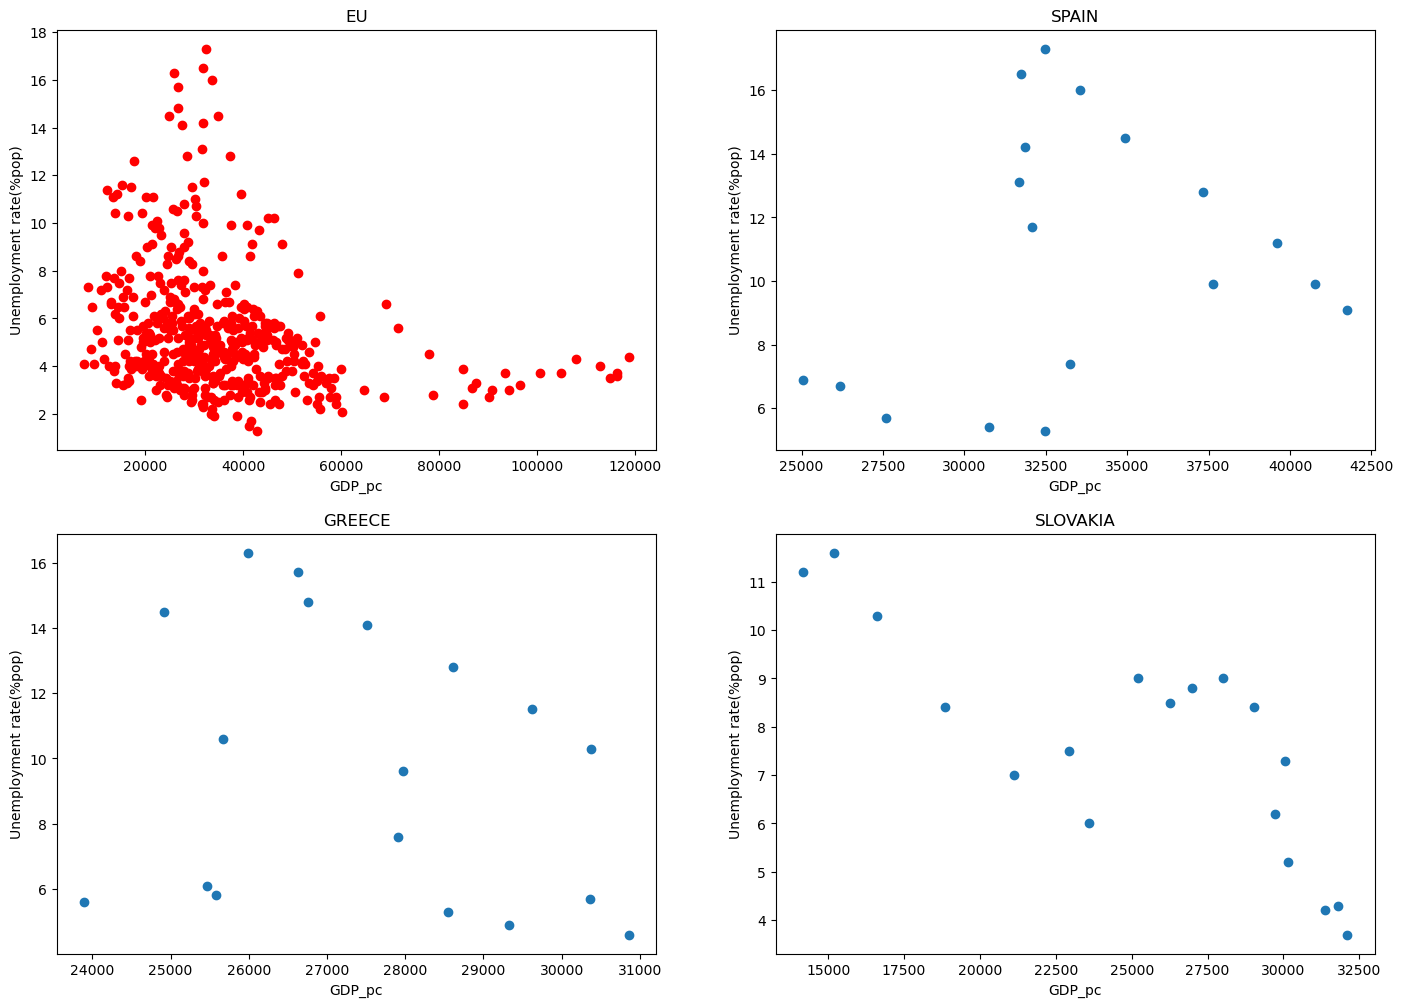

In [80]:
Relations("GDP_pc")

Analysis of the GDP and Unemployment rate correlation for the selected countries and EU

In [81]:
Correlations_data[['ISO','GDP_pc']]

,ISO,GDP_pc
0,GRC,-0.254760
1,ESP,0.245748
2,SVK,-0.784161
3,EU,-0.276560


Rappresentation of the differet levels of correlation 
(the correlation level is shown in absolute values since we want to focus on its strenght) 

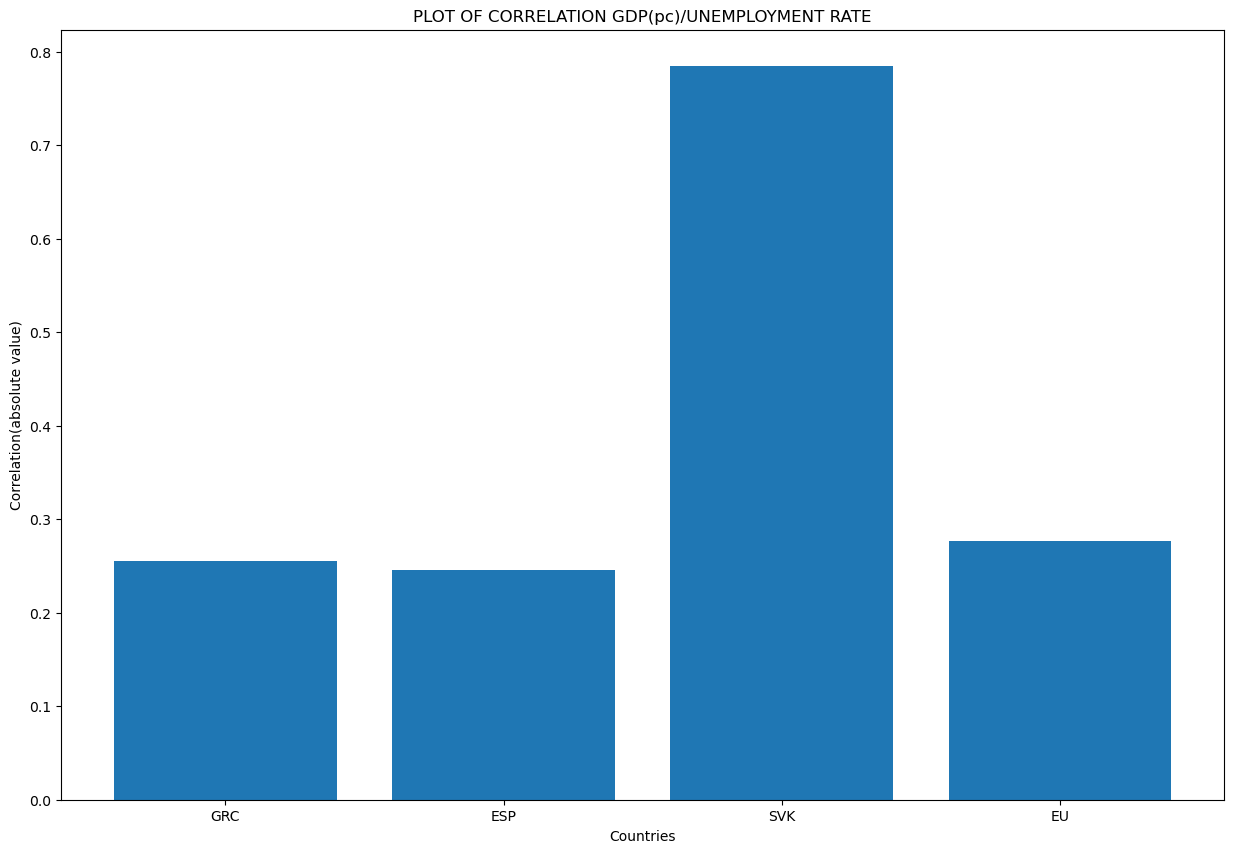

In [82]:
Corrplot('GDP_pc',"PLOT OF CORRELATION GDP(pc)/UNEMPLOYMENT RATE")

##NET MIGRATION

Net Migration and Unemployment rate scatterplots of each selected countries and EU

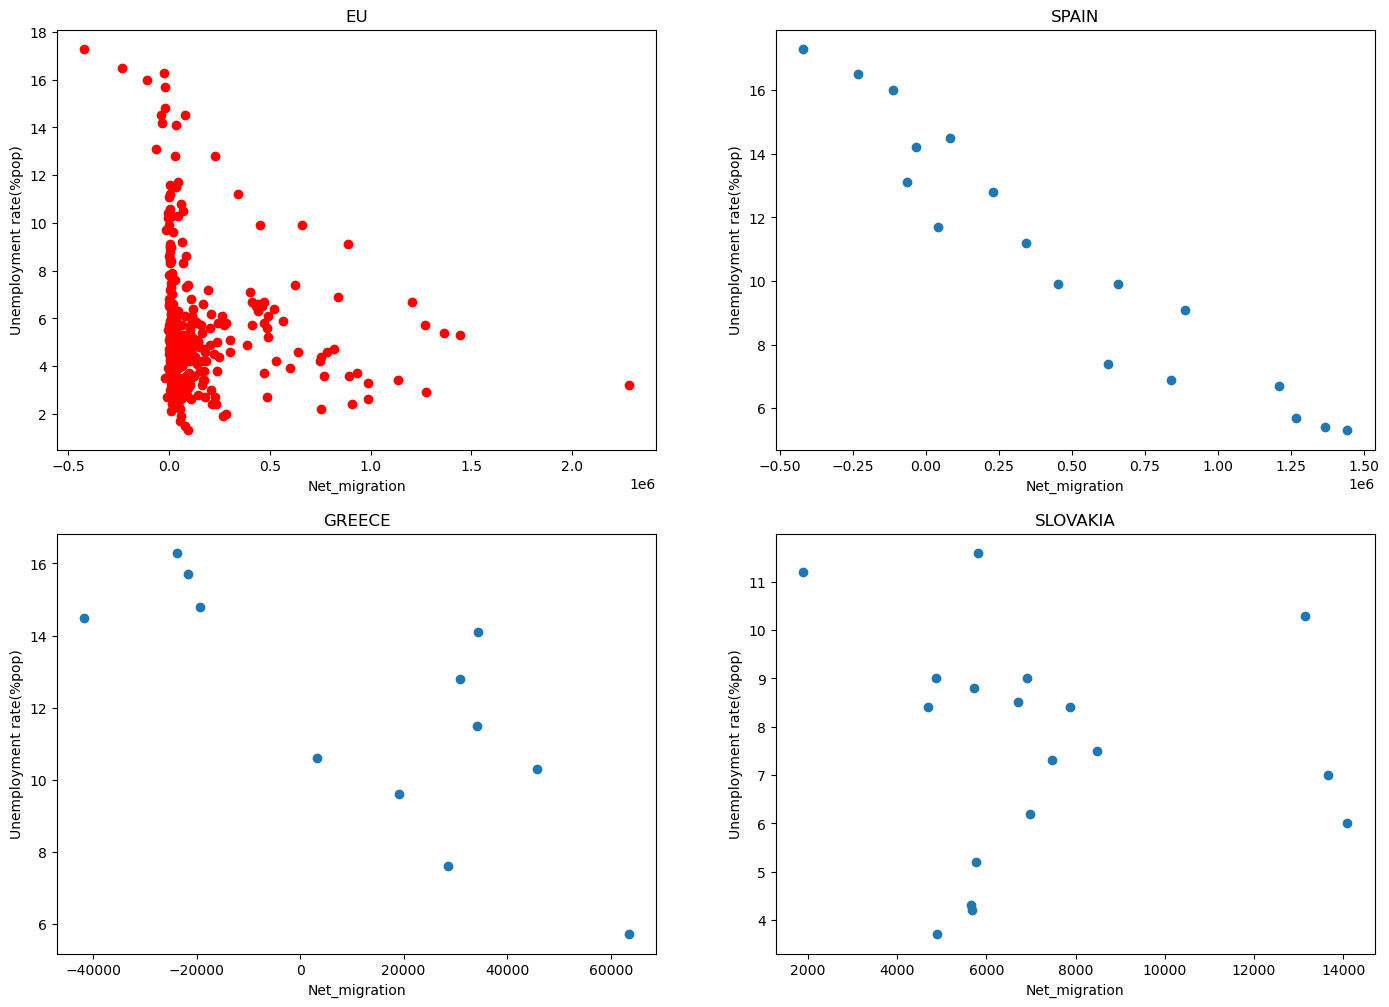

In [83]:
Relations("Net_migration")

Analysis of Net Migration and Unemployment rate correlation for the selected countries and EU

In [84]:
Correlations_data[['ISO',"Net_migration"]]

,ISO,Net_migration
0,GRC,-0.759196
1,ESP,-0.958519
2,SVK,-0.061866
3,EU,-0.141367


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

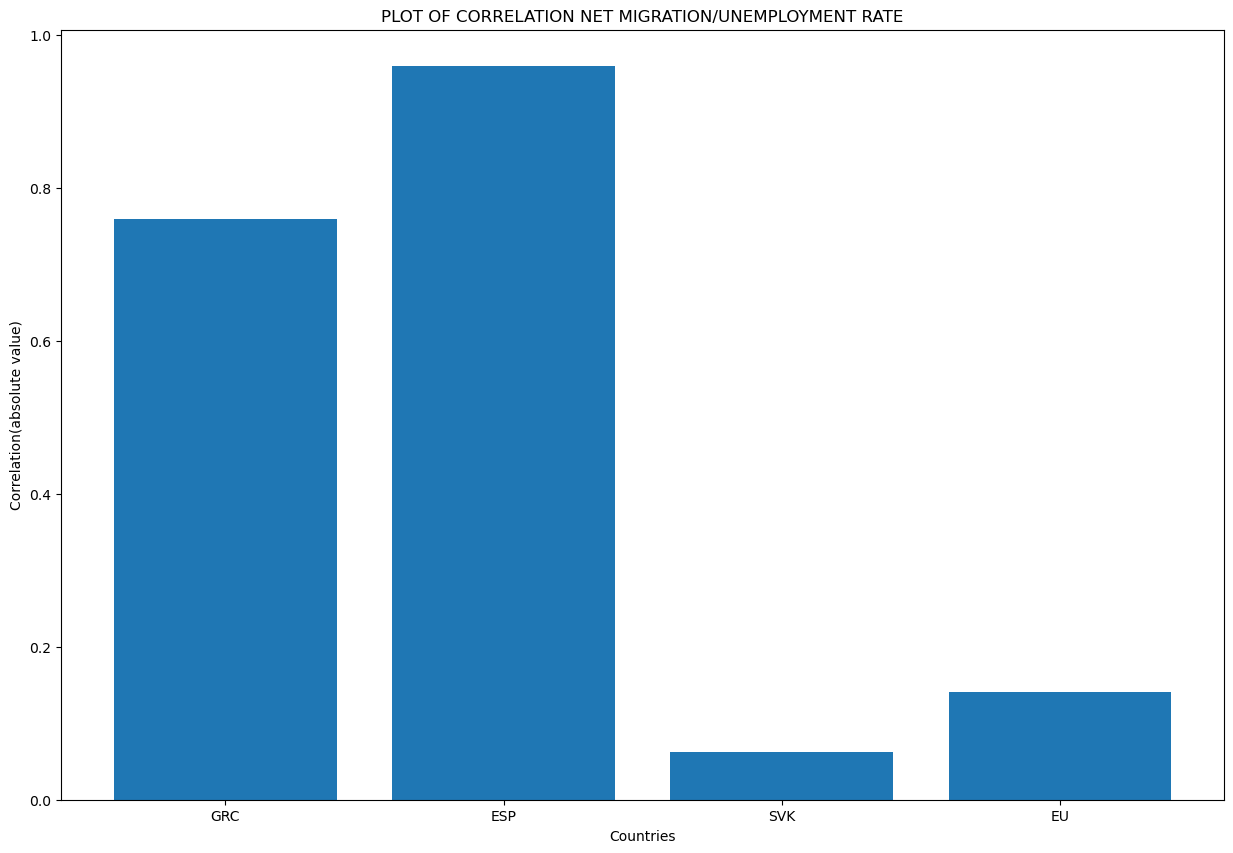

In [85]:
Corrplot("Net_migration","PLOT OF CORRELATION NET MIGRATION/UNEMPLOYMENT RATE")

##MINIMUM WAGE

Minimum Wage and Unemployment rate scatterplots of each selected countries and EU

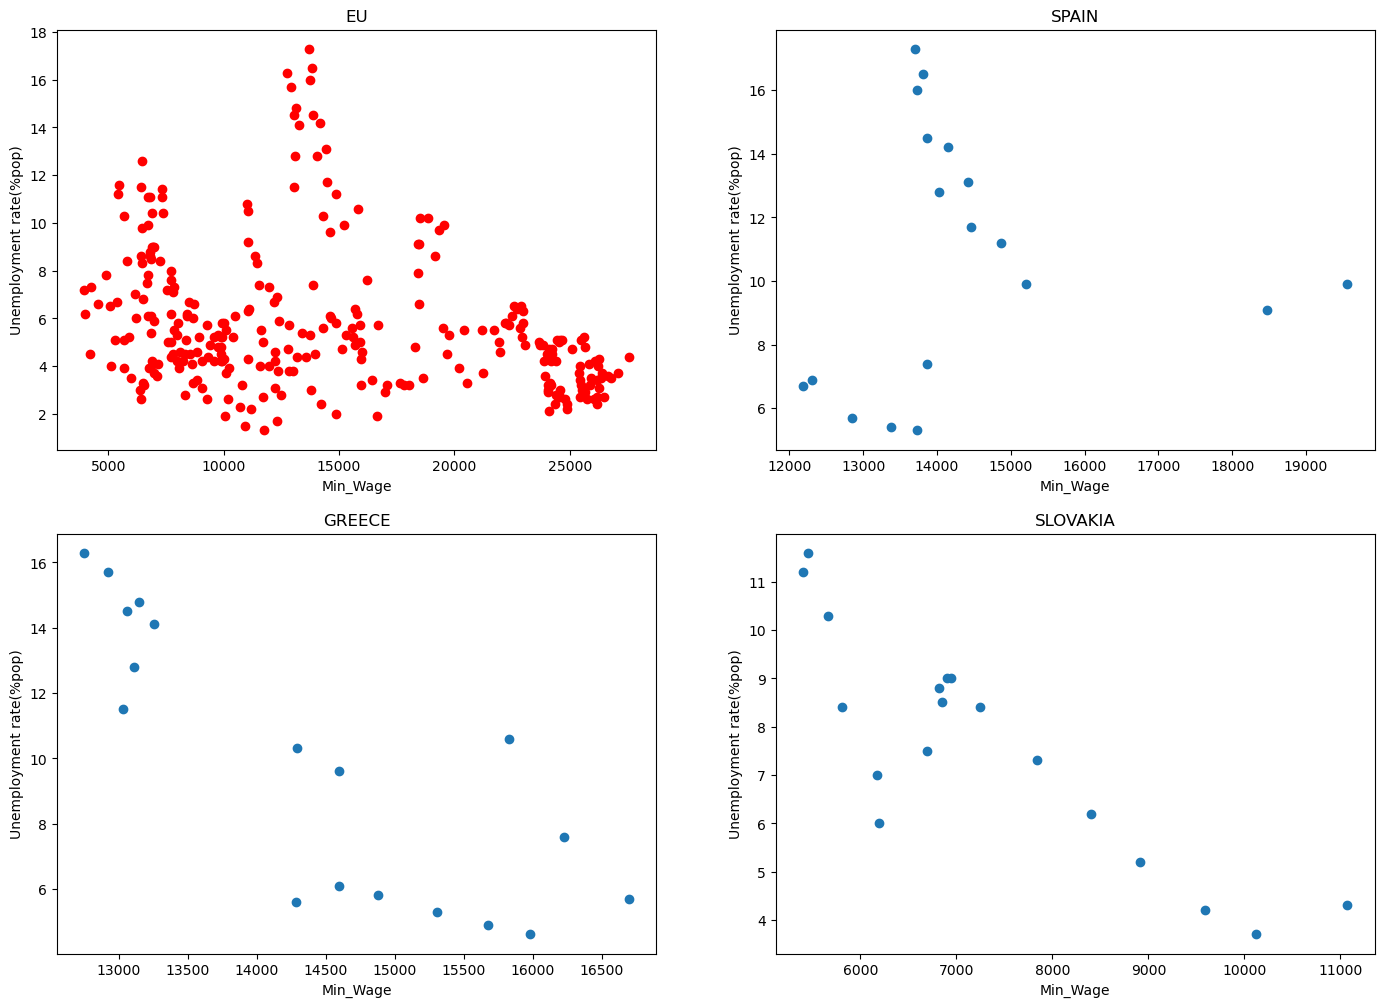

In [86]:
Relations("Min_Wage")

Analysis of the Minimum Wage and Unemployment rate correlation for the selected countries and EU

In [87]:
Correlations_data[['ISO',"Min_Wage"]]

,ISO,Min_Wage
0,GRC,-0.821997
1,ESP,0.073632
2,SVK,-0.854230
3,EU,-0.293222


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

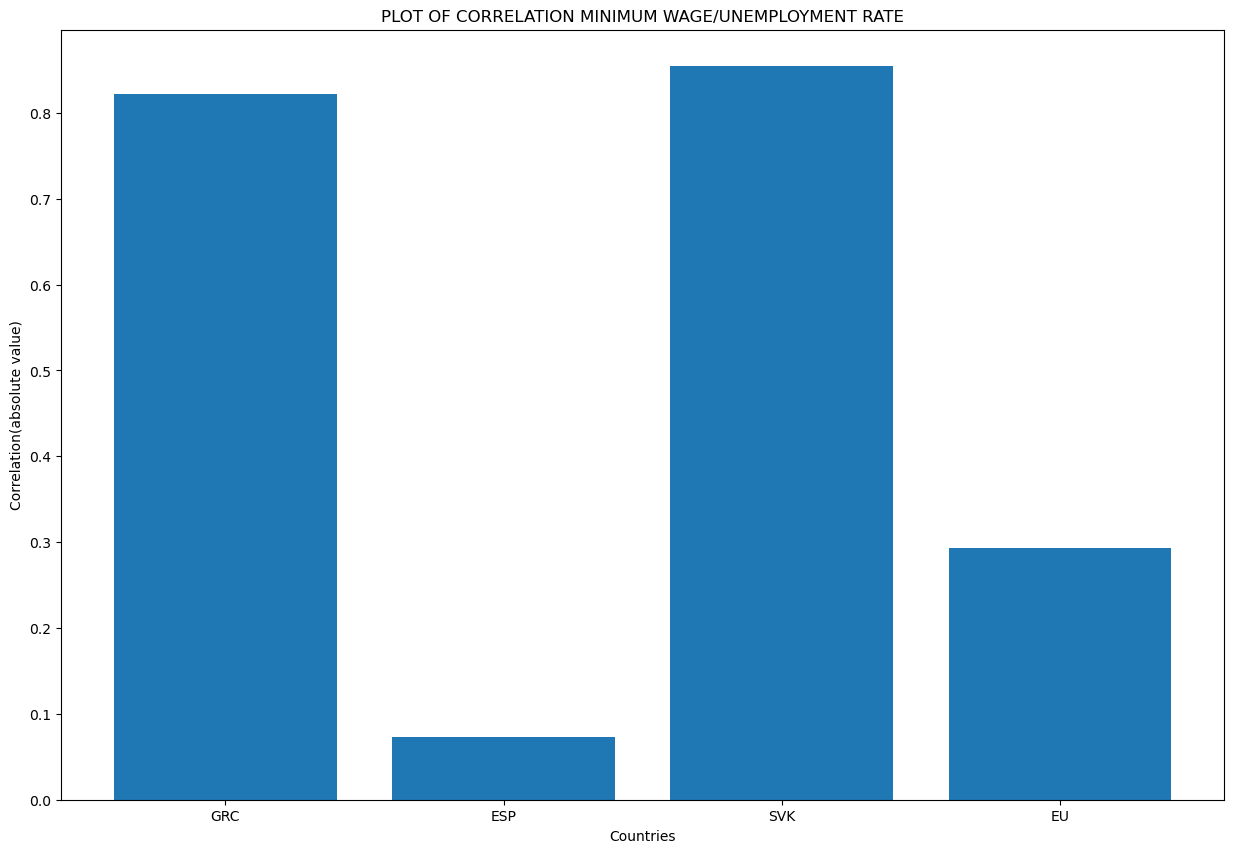

In [88]:
Corrplot("Min_Wage","PLOT OF CORRELATION MINIMUM WAGE/UNEMPLOYMENT RATE")

##LABOUR COST

Labour Cost and Unemployment rate scatterplots of each selected countries and EU

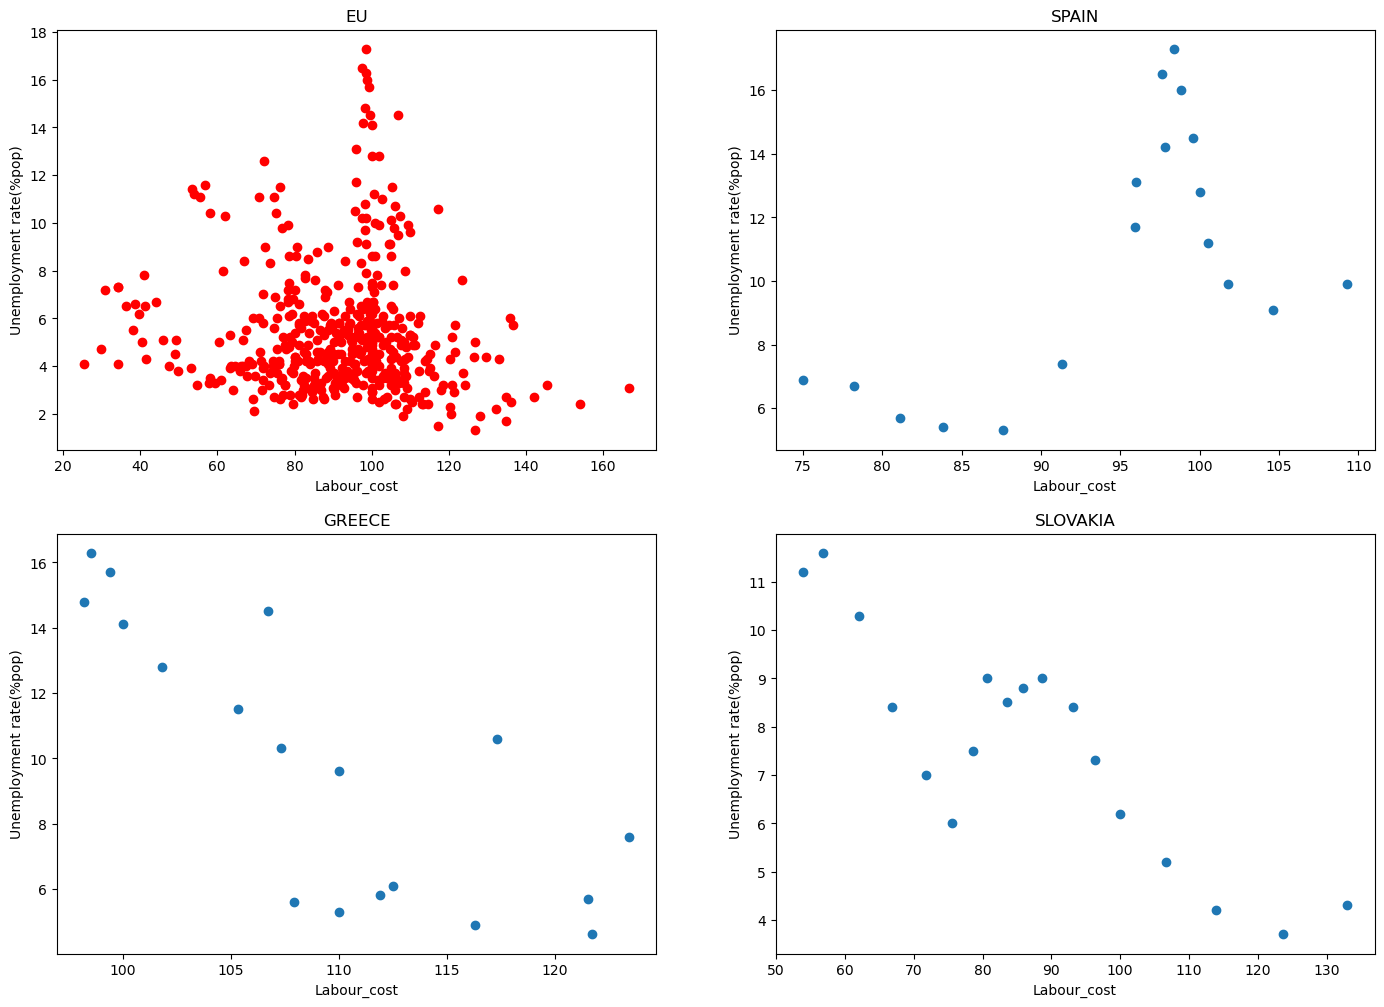

In [89]:
Relations("Labour_cost")

Analysis of the Labour Cost and Unemployment rate correlation for the selected countries and EU

In [90]:
Correlations_data[['ISO',"Labour_cost"]]

,ISO,Labour_cost
0,GRC,-0.791098
1,ESP,0.614023
2,SVK,-0.859518
3,EU,-0.087830


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

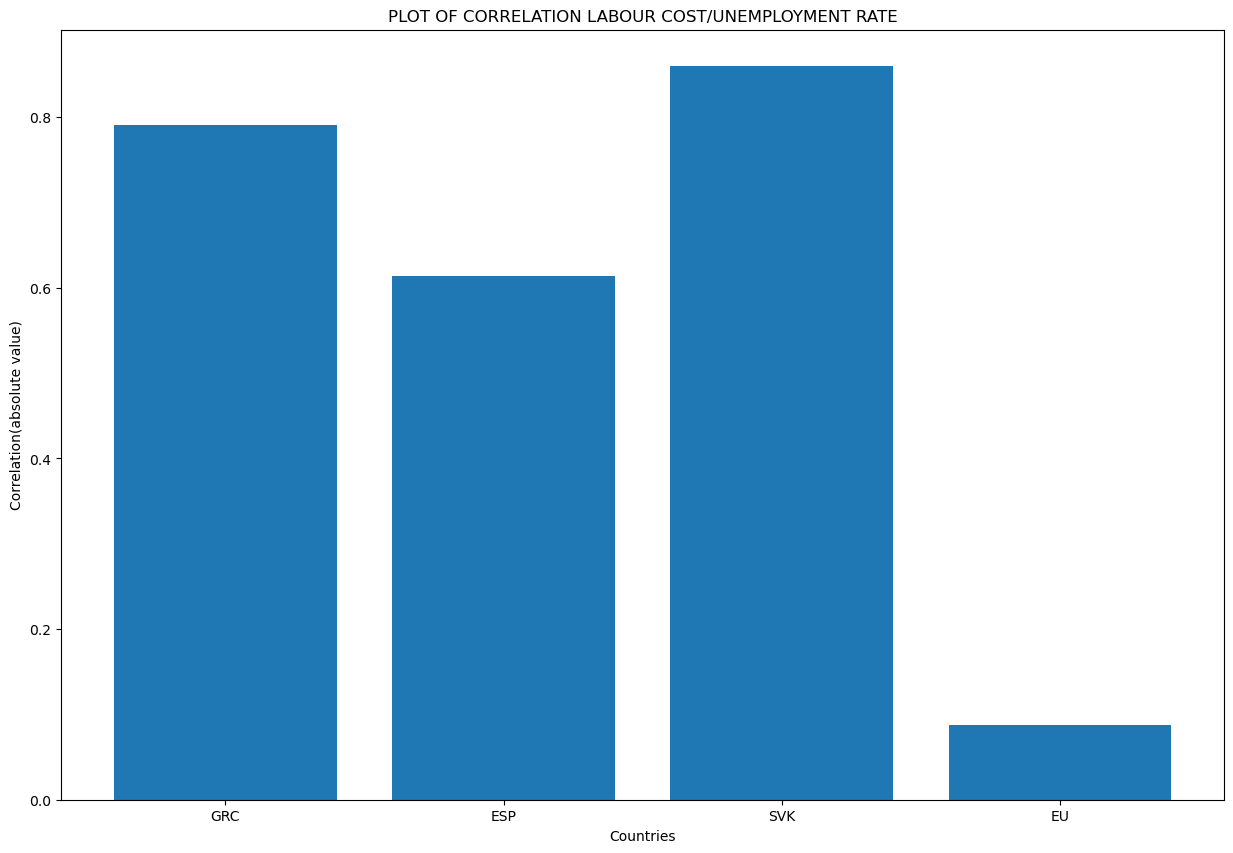

In [91]:
Corrplot("Labour_cost","PLOT OF CORRELATION LABOUR COST/UNEMPLOYMENT RATE")

##UNEMPLOYMENT EXPEDITURE


Unemployment Expediture and Unemployment rate scatterplots of each selected countries and EU

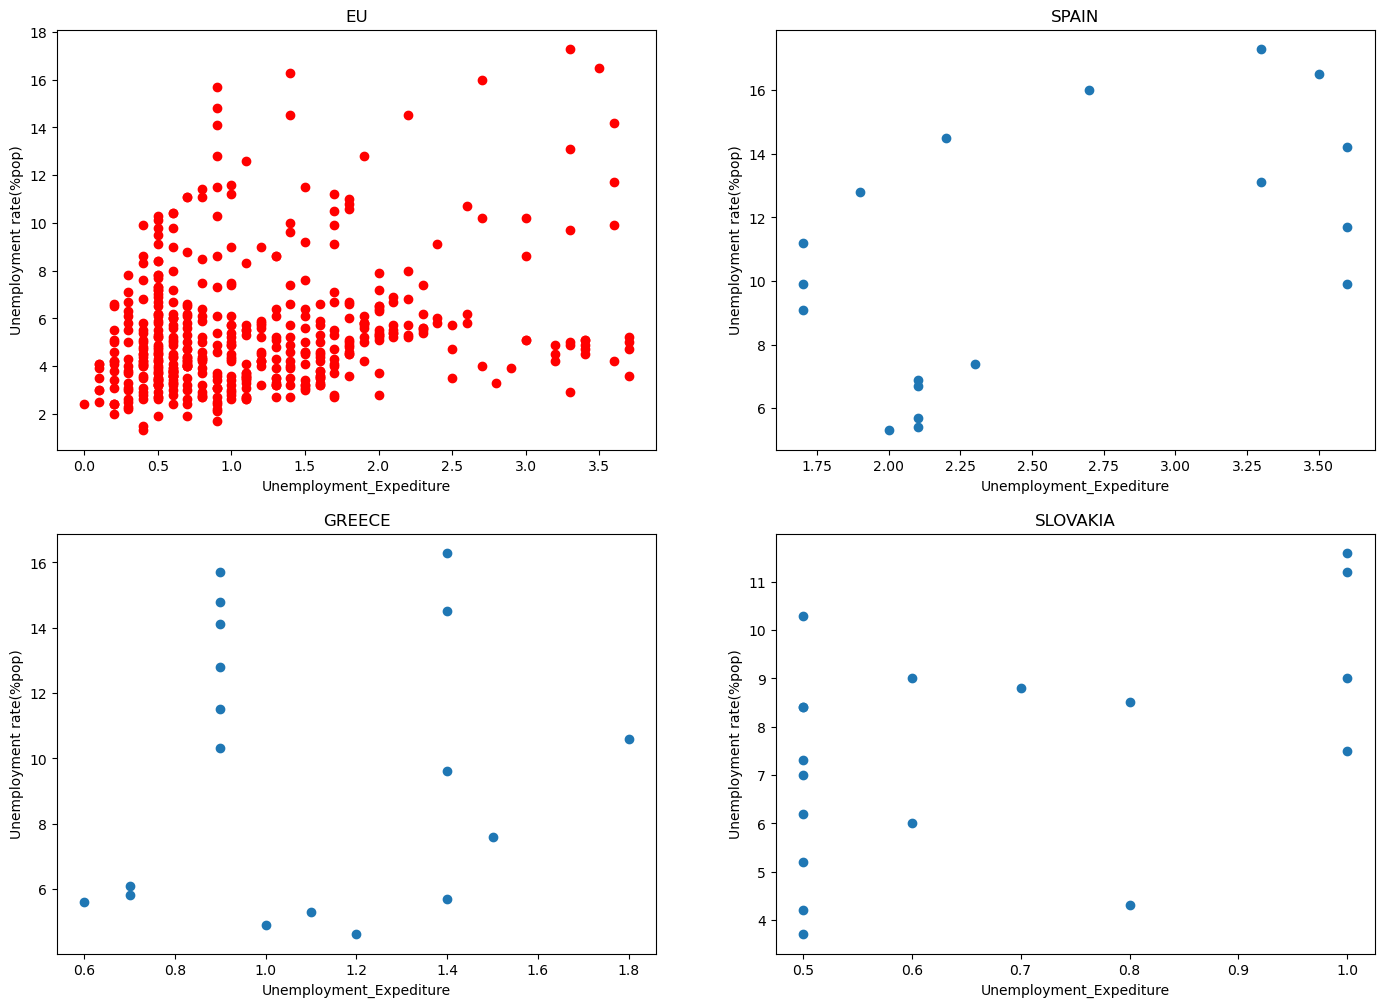

In [92]:
Relations("Unemployment_Expediture")

Analysis of the Unemployment Expediture and Unemployment rate correlation for the selected countries and EU

In [93]:
Correlations_data[['ISO',"Unemployment_Expediture"]]

,ISO,Unemployment_Expediture
0,GRC,0.120680
1,ESP,0.556354
2,SVK,0.482510
3,EU,0.245709


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

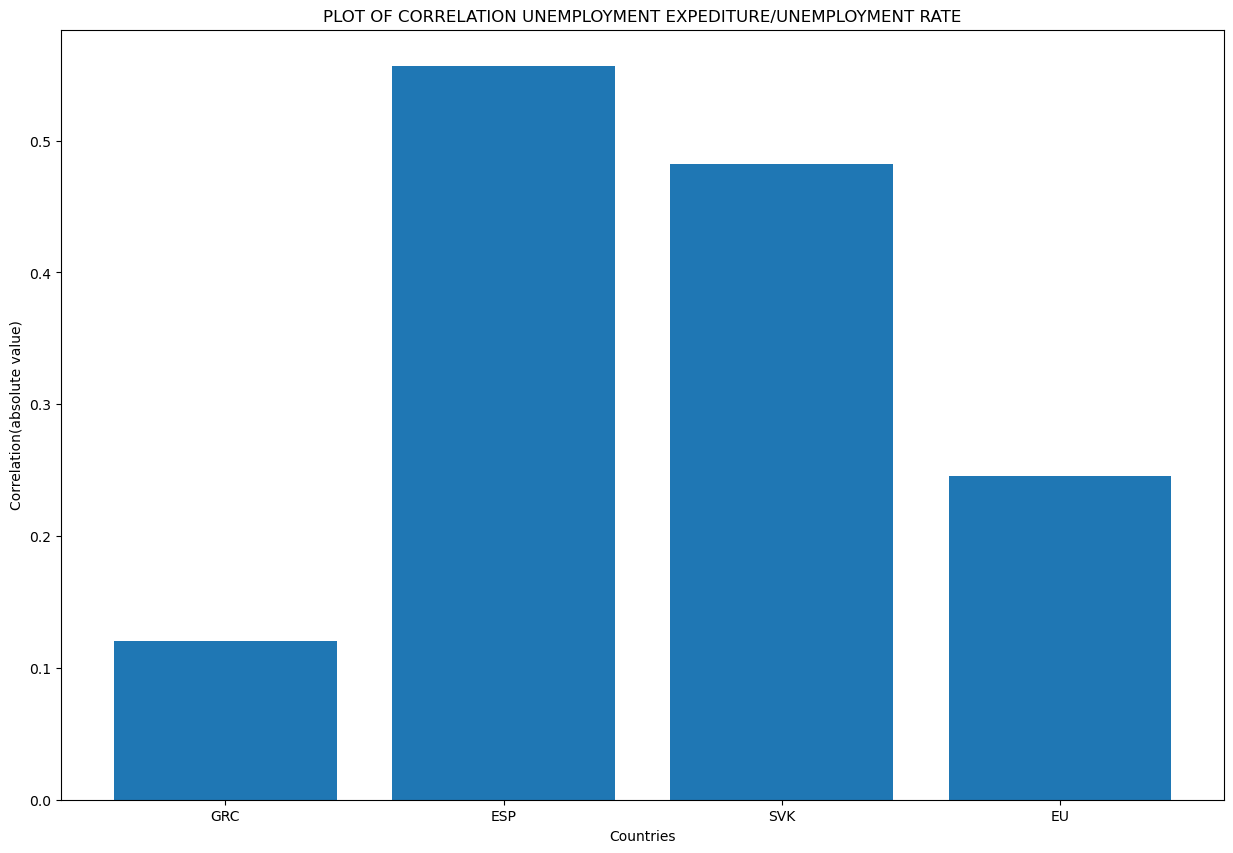

In [94]:
Corrplot("Unemployment_Expediture","PLOT OF CORRELATION UNEMPLOYMENT EXPEDITURE/UNEMPLOYMENT RATE")

##EDUCATION RATE (ED 0-2)

Education Rate(ED 0-2) and Unemployment rate scatterplots of each selected countries and EU

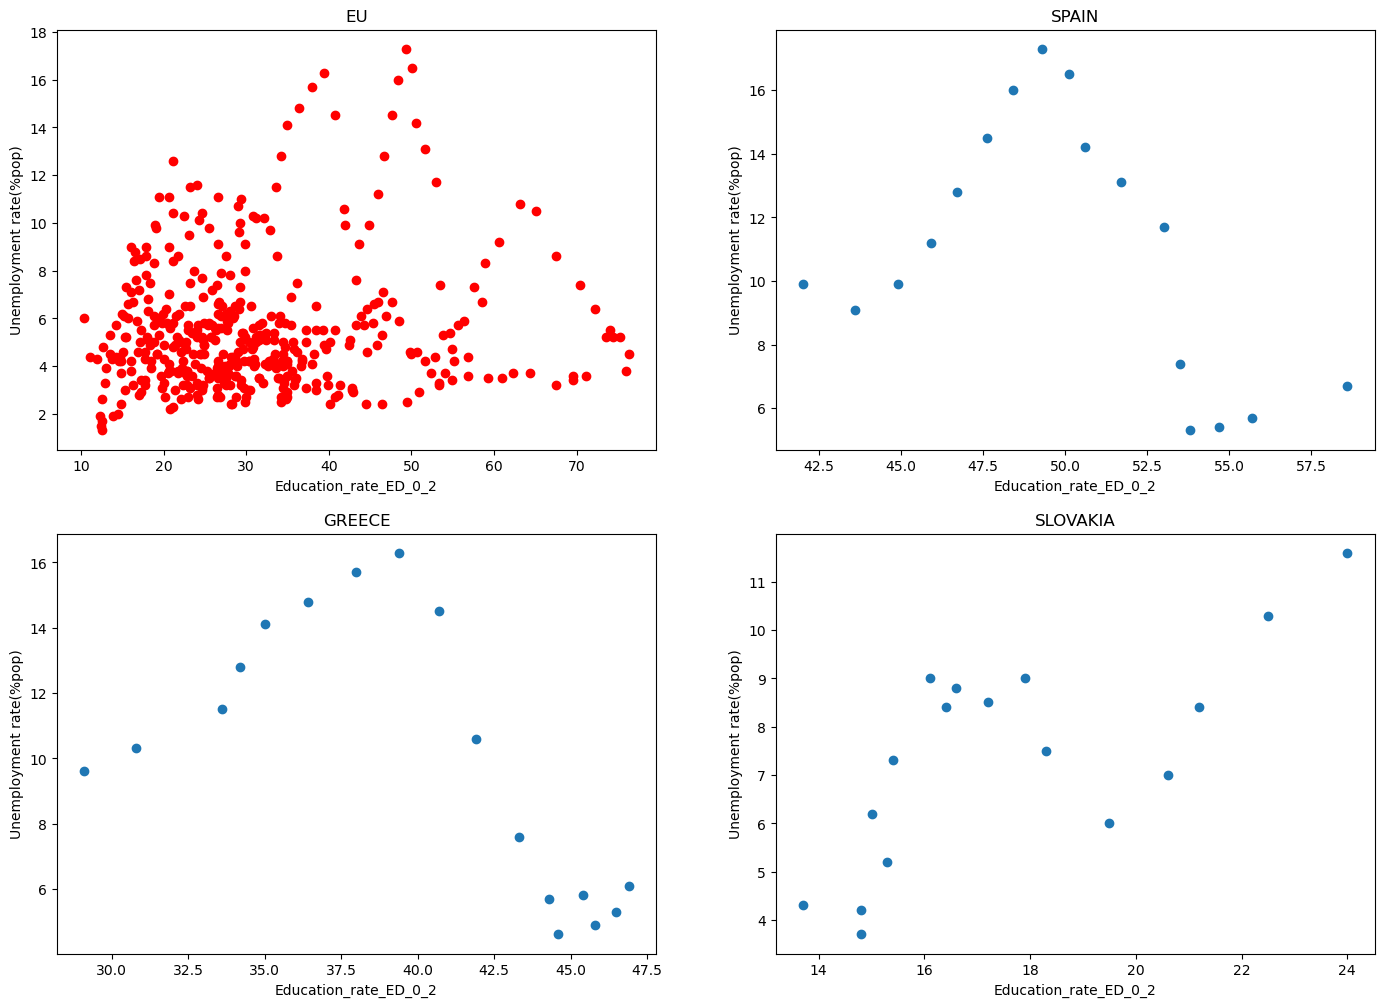

In [95]:
Relations("Education_rate_ED_0_2")


Analysis of the Education Rate(ED 0-2) and Unemployment rate correlation for the selected countries and EU

In [96]:
Correlations_data[['ISO',"Education_rate_ED_0_2"]]

,ISO,Education_rate_ED_0_2
0,GRC,-0.611822
1,ESP,-0.412720
2,SVK,0.714066
3,EU,0.116095


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

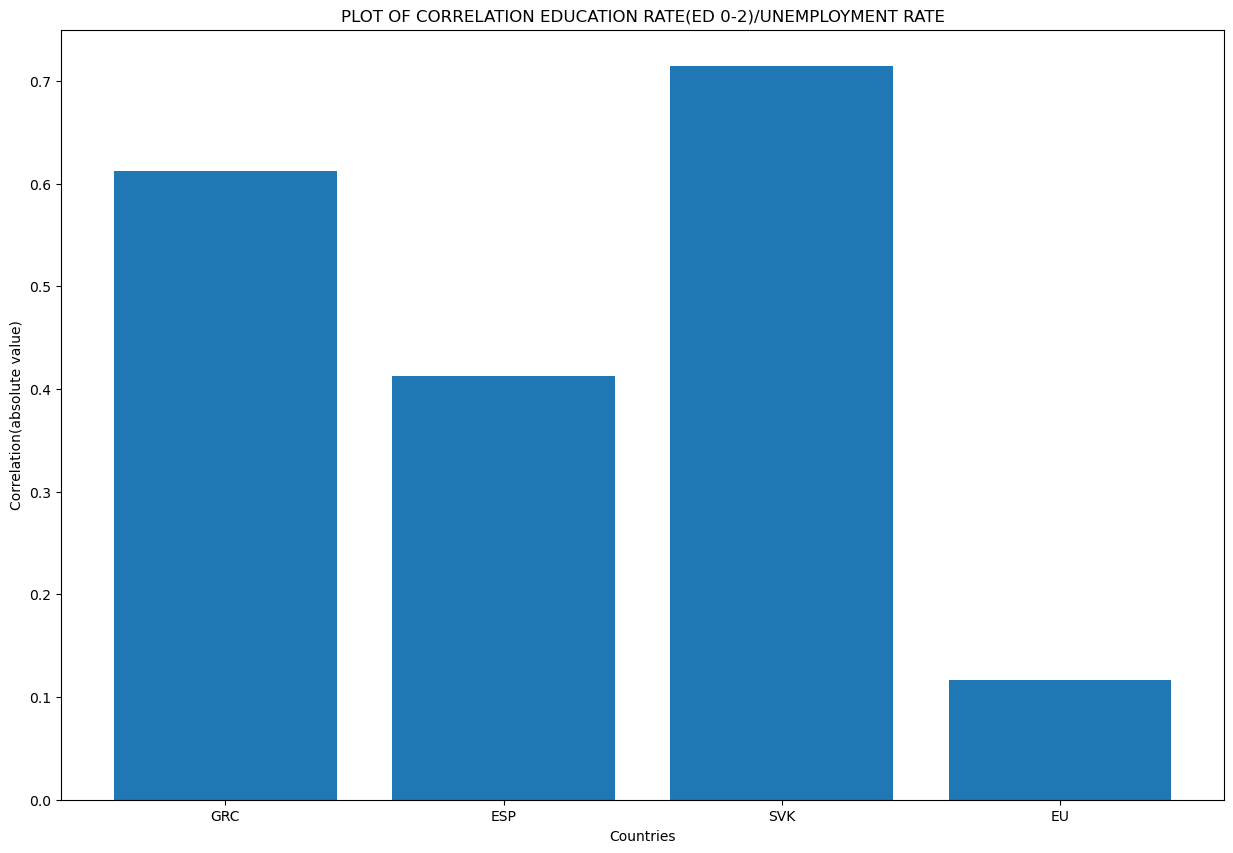

In [97]:
Corrplot("Education_rate_ED_0_2","PLOT OF CORRELATION EDUCATION RATE(ED 0-2)/UNEMPLOYMENT RATE")

##EDUCATION RATE (ED 3-4)

Education Rate(ED 3-4) and Unemployment rate scatterplots of each selected countries and EU

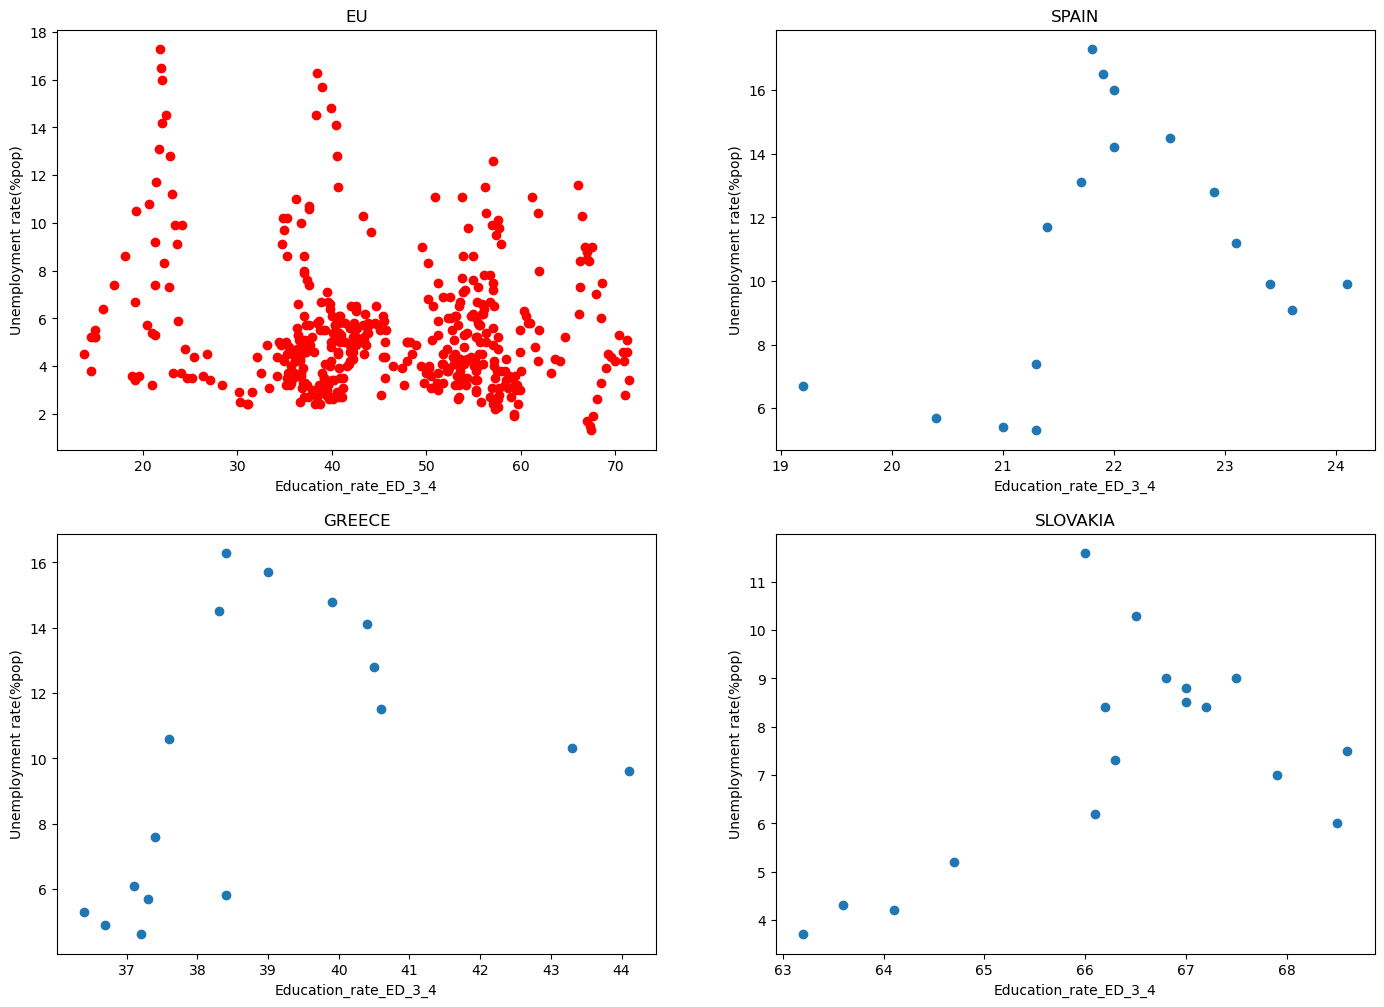

In [98]:
Relations("Education_rate_ED_3_4")

Analysis of the Education Rate(ED 3-4) and Unemployment rate correlation for the selected countries and EU

In [99]:
Correlations_data[['ISO',"Education_rate_ED_3_4"]]

,ISO,Education_rate_ED_3_4
0,GRC,0.423330
1,ESP,0.337756
2,SVK,0.562674
3,EU,-0.151780


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

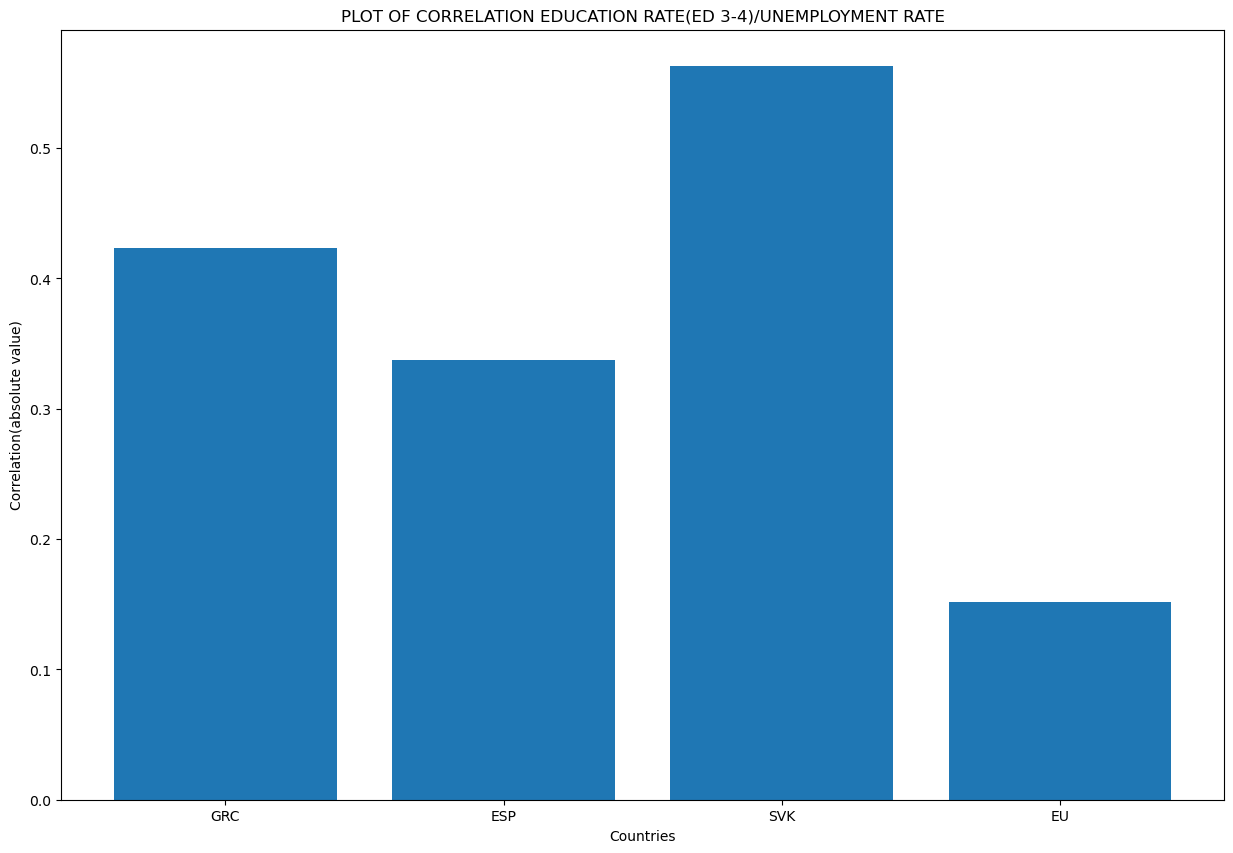

In [100]:
Corrplot("Education_rate_ED_3_4","PLOT OF CORRELATION EDUCATION RATE(ED 3-4)/UNEMPLOYMENT RATE")

##EDUCATION RATE (ED 5-8)

Education Rate(ED 5-8) and Unemployment rate scatterplots of each selected countries and EU

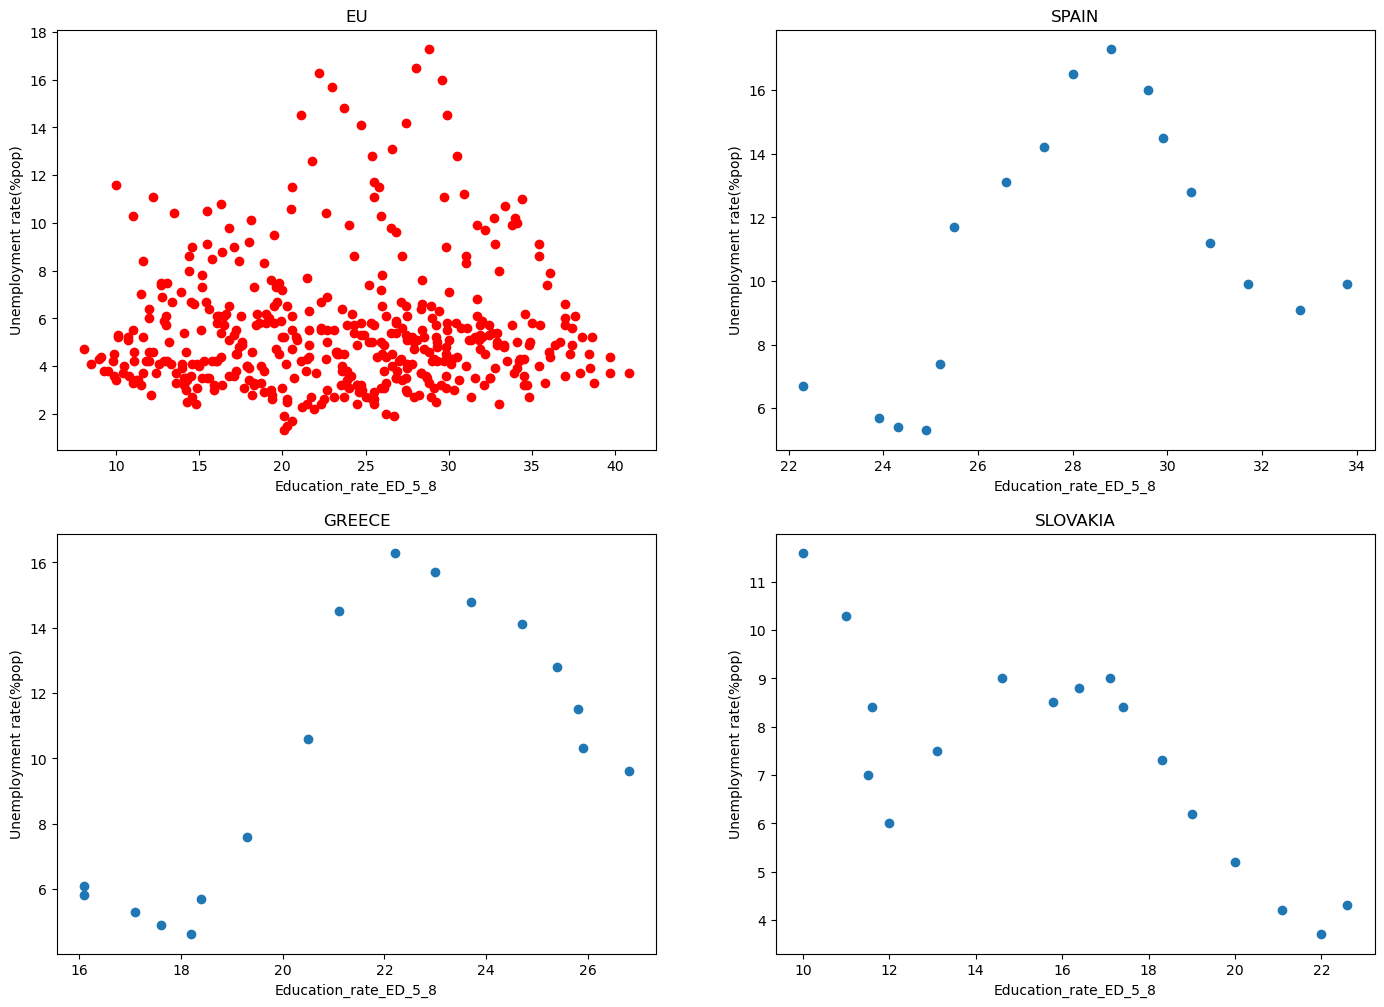

In [101]:
Relations("Education_rate_ED_5_8")

Analysis of the Education Rate(ED 5-8) and Unemployment rate correlation for the selected countries and EU

In [102]:
Correlations_data[['ISO',"Education_rate_ED_5_8"]]

,ISO,Education_rate_ED_5_8
0,GRC,0.698500
1,ESP,0.434450
2,SVK,-0.743464
3,EU,0.052135


Rappresentation of the differet levels of correlation (the correlation level is shown in absolute values since we want to focus on its strenght)

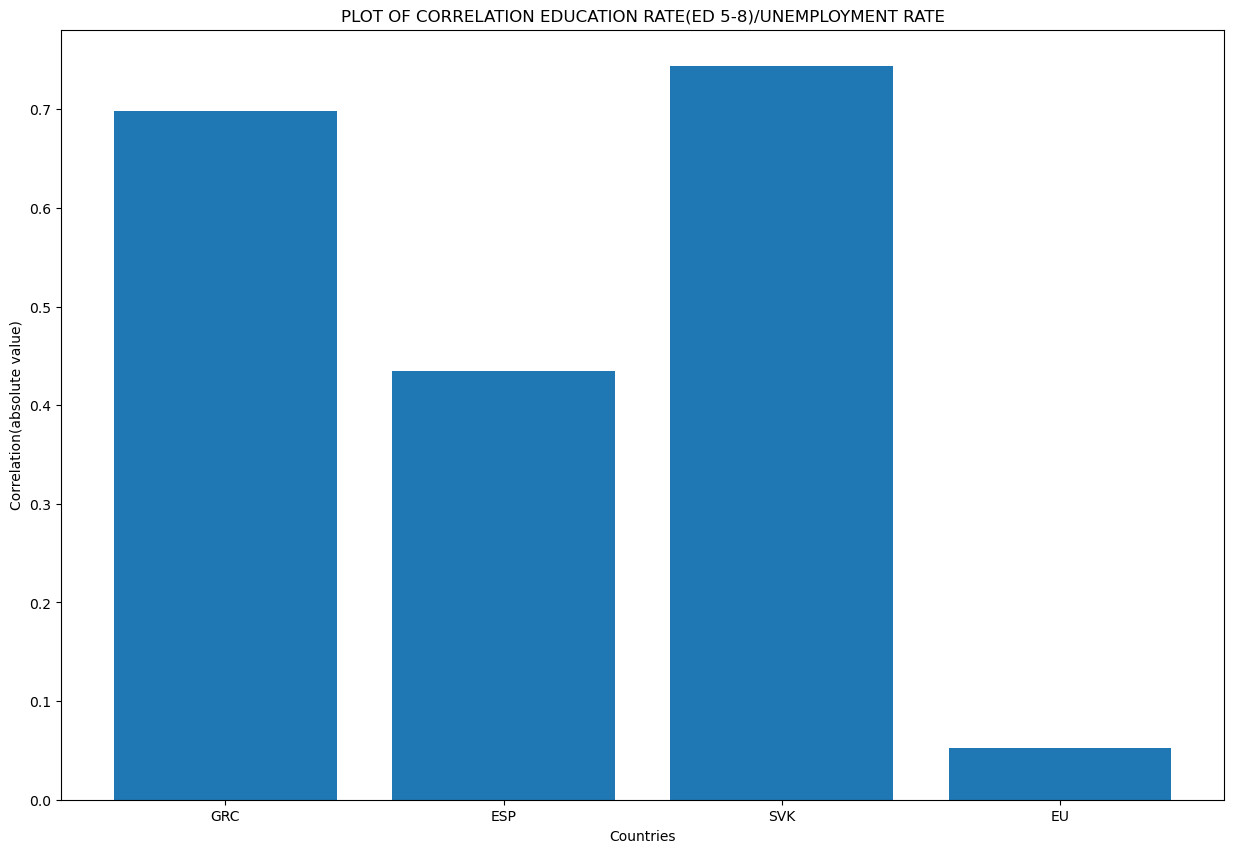

In [103]:
Corrplot("Education_rate_ED_5_8","PLOT OF CORRELATION EDUCATION RATE(ED 5-8)/UNEMPLOYMENT RATE")

#**MODEL CREATION WITH ALL THE PREDICTORS**

# Complete Model on Spain

Create a model with all the predictors

In [104]:
Spain_Data

,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,,,,
2003,6.9,25041.0,839035.0,12300.25,75.0,2.1,NaN,NaN,NaN
2004,6.7,26181.9,1207744.0,12183.50,78.2,2.1,58.6,19.2,22.3
2005,5.7,27600.9,1267945.0,12846.06,81.1,2.1,55.7,20.4,23.9
2006,5.4,30745.7,1365373.0,13374.08,83.8,2.1,54.7,21.0,24.3
2007,5.3,32462.9,1443077.0,13725.92,87.6,2.0,53.8,21.3,24.9
2008,7.4,33242.2,624854.0,13867.98,91.3,2.3,53.5,21.3,25.2
2009,11.7,32089.2,42428.0,14464.33,95.9,3.6,53.0,21.4,25.5
2010,13.1,31692.5,-65954.0,14420.35,96.0,3.3,51.7,21.7,26.6
2011,14.2,31872.4,-35431.0,14152.46,97.8,3.6,50.6,22.0,27.4


## Cleaning of the Data


This is the data that we will be working on, but some changes need to be made:

1.   Take care of nan values
2.   Scale the values (since the values are from different measures)
3.   Split the data intro training and test set


In [105]:

#Remove NaN Values
#bfill was used since it is a time series data
Spain_Data.fillna(method='bfill', inplace=True)

#Train and test set


# initialize the scaler
scaler = StandardScaler()

train_Spain, test_Spain = train_test_split(Spain_Data, test_size=0.2)
X_train_Spain = train_Spain.iloc[:,1:]
y_train_Spain = train_Spain.iloc[:,0]

X_test_Spain = test_Spain.iloc[:,1:]
y_test_Spain = test_Spain.iloc[:,0]

#Categories the columns
X_columns = Spain_Data.columns[1:]
X_Spain = Spain_Data[X_columns]
y_columns = Spain_Data.columns[0]
y_Spain = Spain_Data[y_columns]




Spain_Data_Scaled = Spain_Data.copy()
# fit and transform the data
Spain_Data_Scaled[Spain_Data_Scaled.columns] = scaler.fit_transform(Spain_Data_Scaled)


# Split the data into training and testing sets
train_Spain_Scaled, test_Spain_Scaled = train_test_split(Spain_Data_Scaled, test_size=0.2)

X_train_Spain_Scaled = train_Spain_Scaled.iloc[:,1:]
y_train_Spain_Scaled = train_Spain_Scaled.iloc[:,0]

X_test_Spain_Scaled = test_Spain_Scaled.iloc[:,1:]
y_test_Spain_Scaled = test_Spain_Scaled.iloc[:,0]


#Categories the columns
X_columns = Spain_Data_Scaled.columns[1:]
X_Spain_Scaled = Spain_Data_Scaled[X_columns]
y_columns = Spain_Data_Scaled.columns[0]
y_Spain_Scaled = Spain_Data_Scaled[y_columns]

## Multiple Linear Regression.

After Preparing the data, it is time so test our first model which would be Multiple Linear Regression.


In [106]:


# create a multiple linear regression model
model_multiple_regression = sm.OLS(y_train_Spain_Scaled, sm.add_constant(X_train_Spain_Scaled)).fit()

#Summary
print(model_multiple_regression.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment_rate   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     14.36
Date:                Fri, 16 Jun 2023   Prob (F-statistic):            0.00469
Time:                        15:52:41   Log-Likelihood:                 3.8256
No. Observations:                  14   AIC:                             10.35
Df Residuals:                       5   BIC:                             16.10
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\SAMI\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The p-value related to the F-statistic is low (< 0.000231 < 0.05), so the linear regression is
significant. The quality of linear regression model can be assessed using residual standard error(MSE) and R2
statistic. so let's calculate these values with the test set to avoid overfitting.



### Model Criticism

In [107]:
# make predictions on the test data
y_pred_Spain_Scaled = model_multiple_regression.predict(sm.add_constant(X_test_Spain_Scaled))

# calculate the mean squared error

mse = mean_squared_error(y_test_Spain_Scaled, y_pred_Spain_Scaled)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.015502318946675291


MSE = 0.2779 tells us that the regression model predicts the unemployment rate with an average error of about 0..2779 (The values are scaled). However, there is no universally acceptable threshold for the MSE. Therefore The R²
statistic has an advantage over MSE since it
always yield a value between 0 and 1. In this cases, adj R² = 0.974 means that 97.4% of the the variability in unemployment rate is explained by the regression model. Hence, the linear regression is significant. 


But the problem of high p-values related to the coefficients, Therefore we can conclude that there is a problem with the model.

Let's check for homoscedasticity and normality since multiple linear regression makes those assumptions


In [108]:
# check for normality of residuals
residuals = model_multiple_regression.resid
p_value_shapiro = shapiro(residuals)[1]
print('The p-value for the normality of the residuals is: ',round(p_value_shapiro,2))

# check for homoscedasticity
p_value_bp = het_breuschpagan(residuals, sm.add_constant(X_train_Spain_Scaled))[1]
print('The p-value for homoscedasticity is: ',round(p_value_bp,2))



The p-value for the normality of the residuals is:  0.94
The p-value for homoscedasticity is:  0.59


According to the p-values, our data suffers especially from anormality of the residuals and homoscedasticity . Let's make a plot to visualize the problem

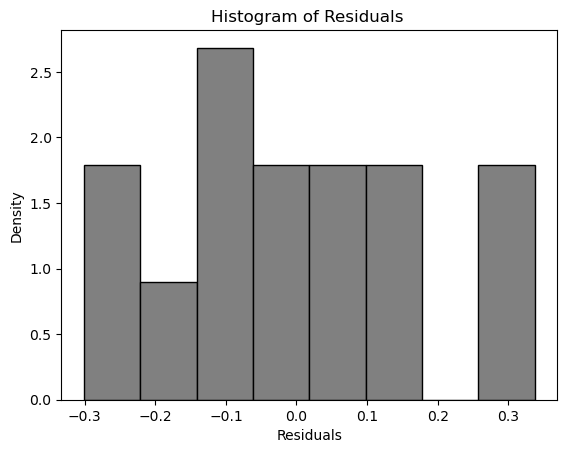

In [109]:
residuals = model_multiple_regression.resid

# create a histogram of the residuals
plt.hist(residuals, bins=8, density=True, histtype='bar', color='gray', ec='black')

# add labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals ')

# display the histogram
plt.show()

4


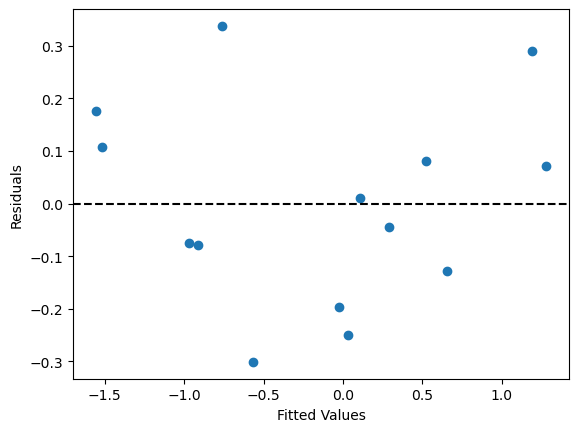

In [110]:
# create a scatter plot of the residuals versus the fitted values

y_pred = model_multiple_regression.predict(sm.add_constant(X_train_Spain_Scaled))
residuals = y_train_Spain_Scaled - y_pred

print(len(y_pred_Spain_Scaled))
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted Values')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Residuals')
plt.show()

One way to get rid if anormality of the residuals is to Transform the data: to transform the data, such as taking the logarithm of the response variable or the predictor variables, in order to make the residuals more normally distributed.

Since we cannot transform negative values to log, we will be dropping the immigrants variable for this particualr analysis

In [111]:
X_log_Spain = np.log(X_Spain.iloc[:,[0,2,3,4,5,6,7]])
y_log_Spain = np.log(y_Spain)

X_train_log_Spain, X_test_log_Spain, y_train_log_Spain, y_test_log_Spain = train_test_split(X_log_Spain, y_log_Spain, test_size=0.2, random_state=0)

In [112]:

# create a multiple linear regression model
model_multiple_log = sm.OLS(y_train_log_Spain, sm.add_constant(X_train_log_Spain)).fit()

#Summary
print(model_multiple_log.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment_rate   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     16.57
Date:                Fri, 16 Jun 2023   Prob (F-statistic):            0.00156
Time:                        15:52:41   Log-Likelihood:                 14.620
No. Observations:                  14   AIC:                            -13.24
Df Residuals:                       6   BIC:                            -8.127
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\SAMI\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [113]:
# check for normality of residuals
residuals = model_multiple_log.resid
p_value_shapiro = shapiro(residuals)[1]
print('The p-value for the normality of the residuals is: ',round(p_value_shapiro,2))


The p-value for the normality of the residuals is:  0.65


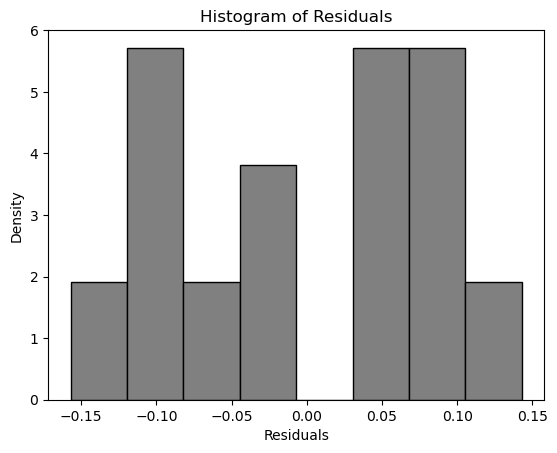

In [114]:
residuals = model_multiple_log.resid

# create a histogram of the residuals
plt.hist(residuals, bins=8, density=True, histtype='bar', color='gray', ec='black')

# add labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals')

# display the histogram
plt.show()

Since the transformation of the variables to log didn't help us in increasing the performance of the model. it is safe to say that a better model can be found for this particular project.

## Quantile Regression

One  model that might be adequate for this situation is Quantile Regression:

It's robust to outliers and does not assume normality of the residuals, so it may be useful for data that is skewed or has outliers.

In [115]:


# specify the quantile you want to estimate (e.g. 0.5 for median)
quantile = 0.5

# create the quantile regression model
model = smf.quantreg('Unemployment_rate	~ GDP_pc + Net_migration + Min_Wage + Labour_cost + Unemployment_Expediture +  Education_rate_ED_0_2 + Education_rate_ED_3_4 + Education_rate_ED_5_8', data=train_Spain_Scaled)

# fit the model for the specified quantile
result = model.fit(q=quantile)

# print the model summary
print(result.summary())


                         QuantReg Regression Results                          
Dep. Variable:      Unemployment_rate   Pseudo R-squared:               0.8499
Model:                       QuantReg   Bandwidth:                    0.001825
Method:                 Least Squares   Sparsity:                     0.003576
Date:                Fri, 16 Jun 2023   No. Observations:                   14
Time:                        15:52:42   Df Residuals:                        5
                                        Df Model:                            8
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0465      0.001    -86.803      0.000      -0.048      -0.045
GDP_pc                     -0.5907      0.006   -101.213      0.000      -0.606      -0.576
Net_migration              -0.3225      0.001   -215.109      0.000      -0.326

### Model Criticism

This model makes the assumption of multicolinearity, (Multicollinearity occurs when there is a strong correlation between two or more independent variables in a multiple regression analysis).

A VIF value greater than 5 or 10 indicates that there may be multicollinearity present.

In [116]:


# calculate the VIF for each predictor variable
vif = [variance_inflation_factor(X_Spain_Scaled.values, i) for i in range(X_Spain_Scaled.shape[1])]

# print the VIF for each predictor variable
print(vif)

[66.893771303261, 12.429201143296623, 10.984050979306856, 120.0317894134444, 26.773555002639924, 11679.848607621874, 972.4244343794533, 6195.88430104873]


Our data has multicolinearity. One way to try to deal with the presence of Multicollinearity in our data is:



1.   Remove one or more of the highly correlated independent variables.
2.   Use regularization methods such as Ridge or Lasso regression, which can shrink the coefficients of highly correlated variables towards zero, making them less influential in the model.



In [117]:
# Create a correlation matrix
corr_matrix = Spain_Data_Scaled.iloc[:,1:].corr()

# Print the correlation matrix
print(corr_matrix)

# Identify variables with a correlation coefficient greater than a certain threshold (e.g. 0.8)
highly_correlated_vars = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            highly_correlated_vars.append(colname)
Spain_data_Scaled_removed_multi = Spain_Data_Scaled.iloc[:,1:].copy()
Spain_data_Scaled_removed_multi.drop(highly_correlated_vars, axis=1, inplace=True)
Spain_data_Scaled_removed_multi

                           GDP_pc  Net_migration  Min_Wage  Labour_cost  \
GDP_pc                   1.000000      -0.207098  0.741156     0.854535   
Net_migration           -0.207098       1.000000 -0.096178    -0.598772   
Min_Wage                 0.741156      -0.096178  1.000000     0.760155   
Labour_cost              0.854535      -0.598772  0.760155     1.000000   
Unemployment_Expediture -0.212655      -0.647755  0.151112     0.289564   
Education_rate_ED_0_2   -0.921658       0.414048 -0.801620    -0.950486   
Education_rate_ED_3_4    0.939911      -0.370425  0.808825     0.952048   
Education_rate_ED_5_8    0.905800      -0.423424  0.788641     0.938091   

                         Unemployment_Expediture  Education_rate_ED_0_2  \
GDP_pc                                 -0.212655              -0.921658   
Net_migration                          -0.647755               0.414048   
Min_Wage                                0.151112              -0.801620   
Labour_cost             

,GDP_pc,Net_migration,Min_Wage,Unemployment_Expediture
TIME,,,,
2003,-1.831123,0.634506,-1.137946,-0.597186
2004,-1.580399,1.279664,-1.202269,-0.597186
2005,-1.268561,1.385002,-0.837233,-0.597186
2006,-0.577462,1.555479,-0.546322,-0.597186
2007,-0.200091,1.691444,-0.352477,-0.736788
2008,-0.028832,0.259738,-0.274210,-0.317982
2009,-0.282215,-0.759377,0.054348,1.496844
2010,-0.369393,-0.949021,0.030117,1.078038
2011,-0.329859,-0.895612,-0.117476,1.496844


In [118]:
X_Scaled_removed_multi = Spain_data_Scaled_removed_multi.iloc[:,:-1]
# calculate the VIF for each predictor variable
vif = [variance_inflation_factor(X_Scaled_removed_multi.values, i) for i in range(X_Scaled_removed_multi.shape[1])]

# print the VIF for each predictor variable
print(vif)

[2.314438064421348, 1.0528292564783632, 2.2358545619770007]


After removing the variables that have the effect of multicollinearity in our data, we are left with only 3 variables, The response variable Unemployment Rate, Labour_cost , adn the different education levels.

Now let's redo the model with the right variables.

In [119]:


# specify the quantile you want to estimate (e.g. 0.5 for median)
quantile = 0.5

# create the quantile regression model
model_quantile_fixed = smf.quantreg('Unemployment_rate	~ Labour_cost + Education_rate_ED_0_2 + Education_rate_ED_3_4 + Education_rate_ED_5_8', data=train_Spain_Scaled)

# fit the model for the specified quantile
result_quantile_fixed = model_quantile_fixed.fit(q=quantile)

# print the model summary
print(result_quantile_fixed.summary())


                         QuantReg Regression Results                          
Dep. Variable:      Unemployment_rate   Pseudo R-squared:               0.4824
Model:                       QuantReg   Bandwidth:                       1.167
Method:                 Least Squares   Sparsity:                        1.941
Date:                Fri, 16 Jun 2023   No. Observations:                   14
Time:                        15:52:42   Df Residuals:                        9
                                        Df Model:                            4
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1118      0.263     -0.425      0.681      -0.707       0.484
Labour_cost               2.5177      0.980      2.570      0.030       0.302       4.734
Education_rate_ED_0_2    25.3606     27.096      0.936      0.374     -35.936      86.6

It seems that the problem is still present (We can see that with the presence of high p values for the coefficients). 

[link text](https://)## Regularization Methods


Regularization is a method that can take care of this issue. Regulazions such as Ridge or Lasso regression can help to reduce the model's complexity and prevent overfitting. These methods can also help to reduce the collinearity among the variables by shrinking the coefficient estimates towards zero.



So let's use Ridge/Lasso regression and then choose the best better one.

In [120]:


# Create Ridge, Lasso, and Quantile Regression models
ridge = Ridge(alpha=0.5)
lasso = Lasso(alpha=0.5)
quantile = QuantileRegressor(alpha=0.5)

# Fit the models to the data
ridge.fit(X_train_Spain_Scaled, y_train_Spain_Scaled)
lasso.fit(X_train_Spain_Scaled, y_train_Spain_Scaled)

# Print the coefficients
print("Ridge coefficients:")
for coef, col in zip(ridge.coef_, X_train_Spain_Scaled.columns):
    print(f"{col}: {coef}")
print("\nLasso coefficients:")
for coef, col in zip(lasso.coef_, X_train_Spain_Scaled.columns):
    print(f"{col}: {coef}")

Ridge coefficients:
GDP_pc: -0.1556470841409889
Net_migration: -0.5900538823238178
Min_Wage: -0.3676379188478799
Labour_cost: 0.23293249440570257
Unemployment_Expediture: 0.08809112462830836
Education_rate_ED_0_2: -0.19903901319672584
Education_rate_ED_3_4: -0.14625495789338652
Education_rate_ED_5_8: 0.3562181664909041

Lasso coefficients:
GDP_pc: 0.0
Net_migration: -0.33452829174093507
Min_Wage: 0.0
Labour_cost: 0.0
Unemployment_Expediture: 0.0
Education_rate_ED_0_2: -0.0
Education_rate_ED_3_4: 0.0
Education_rate_ED_5_8: 0.0


In [121]:
ridge_r2 = ridge.score(X_test_Spain_Scaled, y_test_Spain_Scaled)
lasso_r2 = lasso.score(X_test_Spain_Scaled, y_test_Spain_Scaled)
print("Ridge R-squared:", ridge_r2)
print("Lasso R-squared:", lasso_r2)


Ridge R-squared: 0.9758930352237959
Lasso R-squared: 0.32561901002304017


In [122]:



ridge_mae = mean_absolute_error(y_test_Spain_Scaled, ridge.predict(X_test_Spain_Scaled))
lasso_mae = mean_absolute_error(y_test_Spain_Scaled, lasso.predict(X_test_Spain_Scaled))

print("Ridge MAE:", ridge_mae)
print("Lasso MAE:", lasso_mae)



Ridge MAE: 0.16586896593433595
Lasso MAE: 0.8898765392983621


According to the 2 different metrics calculated (MAE and R squared), Ridge Regression works best with the data we have in hand.

But still an R squared of 35% is not good enough to conclude this analysis.

## Random Forest

Random Forest: Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. It has similar properties to decision trees and can handle multicollinearity and lack of normality well.

We will be Using RandomForestRegressor since our data is continuous.

In [123]:
#test

In [124]:
X_train_Spain_Scaled.iloc[:,[1,3,4,5,6,7]]

,Net_migration,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,
2017,-0.232449,0.674834,-1.155594,-0.966580,0.968200,0.936561
2004,1.279664,-1.750218,-0.597186,1.711725,-1.986915,-1.571737
2007,1.691444,-0.727999,-0.736788,0.699452,-0.395699,-0.813415
2012,-1.242832,0.359468,1.357242,-0.080841,0.058934,0.090739
2003,0.634506,-2.098208,-0.597186,1.711725,-1.986915,-1.571737
2018,0.319477,0.816205,-1.155594,-1.177470,1.195517,1.169891
2014,-1.028182,0.489964,0.240426,-0.439354,0.134706,0.557400
2016,-0.433233,0.620460,-0.876390,-0.797868,0.816656,0.819896
2009,-0.759377,0.174599,1.496844,0.530740,-0.319927,-0.638417


In [125]:
#test

In [126]:

# create the random forest regressor
regr = RandomForestRegressor(n_estimators=100, random_state=0)

# train the model
regr.fit(X_train_Spain_Scaled, y_train_Spain_Scaled)




RandomForestRegressor(random_state=0)

The n_estimators variable is used to set the number of decision trees in the forest. The larger the number of trees, the more robust the forest will be, but at the cost of increased computational resources and longer training times.

The random_state variable is used to set the random seed for the model. This is useful for reproducibility, as it ensures that the same random sequence of numbers is used each time the model is trained, allowing the results to be replicated.

In [127]:

# use the model to make predictions
y_pred = regr.predict(X_test_Spain_Scaled)


mse = mean_squared_error(y_test_Spain_Scaled, y_pred)
print('The MSE is: ',mse)
r2 = r2_score(y_test_Spain_Scaled, y_pred)
print('The R² is: ',r2)

evs = explained_variance_score(y_test_Spain_Scaled, y_pred)
print('The Explained variance score is: ', evs)

The MSE is:  0.08894852885657065
The R² is:  0.9290629643129329
The Explained variance score is:  0.9489851088505252


As seen in the Model Criticism part, the Means Squared error is 0.04 which is relatively small, moreover, the R² is 0.81 which means that the predictor variables explain 81% of the response variable. And the Explained variance score is 0.85 (This is a score function to evaluate the quality of the predictions of a regressor, the best possible score is 1.0). 

## Complete Model on Greece Data


In [128]:
Greece_Data

,Unemployment_rate,GDP_pc,Net_migration,Min_Wage,Labour_cost,Unemployment_Expediture,Education_rate_ED_0_2,Education_rate_ED_3_4,Education_rate_ED_5_8
TIME,,,,,,,,,
2003,5.6,23896.5,NaN,14282.41,107.9,0.6,NaN,NaN,NaN
2004,6.1,25460.4,NaN,14591.12,112.5,0.7,46.9,37.1,16.1
2005,5.8,25577.4,NaN,14874.43,111.9,0.7,45.4,38.4,16.1
2006,5.3,28549.1,NaN,15304.26,110.0,1.1,46.5,36.4,17.1
2007,4.9,29320.2,NaN,15672.17,116.3,1.0,45.8,36.7,17.6
2008,4.6,30855.9,NaN,15980.74,121.7,1.2,44.6,37.2,18.2
2009,5.7,30359.1,63466.0,16694.59,121.5,1.4,44.3,37.3,18.4
2010,7.6,27913.0,28536.0,16224.69,123.4,1.5,43.3,37.4,19.3
2011,10.6,25671.3,3347.0,15827.83,117.3,1.8,41.9,37.6,20.5


In [129]:
#Remove NaN Values
#bfill was used since it is a time series data
Greece_Data.fillna(method='bfill', inplace=True)

#Train and test set


# initialize the scaler
scaler = StandardScaler()
Greece_Data_Scaled = Greece_Data.copy()

# fit and transform the data
Greece_Data_Scaled[Greece_Data_Scaled.columns] = scaler.fit_transform(Greece_Data_Scaled)


# Split the data into training and testing sets
train_Greece_Scaled, test_Greece_Scaled = train_test_split(Greece_Data_Scaled, test_size=0.2)

X_train_Greece_Scaled = train_Greece_Scaled.iloc[:,1:]
y_train_Greece_Scaled = train_Greece_Scaled.iloc[:,0]

X_test_Greece_Scaled = test_Greece_Scaled.iloc[:,1:]
y_test_Greece_Scaled = test_Greece_Scaled.iloc[:,0]


#Categories the columns
X_columns = Greece_Data_Scaled.columns[1:]
X_Greece_Scaled = Greece_Data_Scaled[X_columns]
y_columns = Greece_Data_Scaled.columns[0]
y_Greece_Scaled = Greece_Data_Scaled[y_columns]

In [130]:


# create the random forest regressor
regr = RandomForestRegressor(n_estimators=100, random_state=0)

# train the model
regr.fit(X_train_Greece_Scaled, y_train_Greece_Scaled)

RandomForestRegressor(random_state=0)

In [131]:

# use the model to make predictions
y_pred = regr.predict(X_test_Greece_Scaled)


mse = mean_squared_error(y_test_Greece_Scaled, y_pred)
print('The MSE is: ',mse)
r2 = r2_score(y_test_Greece_Scaled, y_pred)
print('The R² is: ',r2)

evs = explained_variance_score(y_test_Greece_Scaled, y_pred)
print('The Explained variance score is: ', evs)

The MSE is:  0.015131653253077252
The R² is:  0.9456323127392017
The Explained variance score is:  0.9532595544013123


For the Country Greece, it is clear that random forest works well also.

## Complete Model on Slovakia Data

In [132]:
#Remove NaN Values
#bfill was used since it is a time series data
Slovakia_Data.fillna(method='bfill', inplace=True)

#Train and test set

# initialize the scaler
scaler = StandardScaler()
Slovakia_Data_Scaled = Slovakia_Data.copy()

# fit and transform the data
Slovakia_Data_Scaled[Slovakia_Data_Scaled.columns] = scaler.fit_transform(Slovakia_Data_Scaled)


# Split the data into training and testing sets
train_Slovakia_Scaled, test_Slovakia_Scaled = train_test_split(Slovakia_Data_Scaled, test_size=0.2)

X_train_Slovakia_Scaled = train_Slovakia_Scaled.iloc[:,1:]
y_train_Slovakia_Scaled = train_Slovakia_Scaled.iloc[:,0]

X_test_Slovakia_Scaled = test_Slovakia_Scaled.iloc[:,1:]
y_test_Slovakia_Scaled = test_Slovakia_Scaled.iloc[:,0]


#Categories the columns
X_columns = Slovakia_Data_Scaled.columns[1:]
X_Slovakia_Scaled = Slovakia_Data_Scaled[X_columns]
y_columns = Slovakia_Data_Scaled.columns[0]
y_Slovakia_Scaled = Slovakia_Data_Scaled[y_columns]

In [133]:


# create the random forest regressor
regr = RandomForestRegressor(n_estimators=100, random_state=0)

# train the model
regr.fit(X_train_Slovakia_Scaled, y_train_Slovakia_Scaled)

RandomForestRegressor(random_state=0)

In [134]:

# use the model to make predictions
y_pred = regr.predict(X_test_Slovakia_Scaled)


mse = mean_squared_error(y_test_Slovakia_Scaled, y_pred)
print('The MSE is: ',mse)
r2 = r2_score(y_test_Slovakia_Scaled, y_pred)
print('The R² is: ',r2)

evs = explained_variance_score(y_test_Slovakia_Scaled, y_pred)
print('The Explained variance score is: ', evs)

The MSE is:  0.2471358489769325
The R² is:  0.6527938905096966
The Explained variance score is:  0.8000230135575768


For the Country Greece, it is clear that random forest works well also.

# **TIME SERIES**

## Spain Data

In a simple univariate time series forecasting, only one variable (the variable of interest) is needed. This is because the variable's past values are used to predict its future values.


ARIMA (Auto-Regressive Integrated Moving Average) model: This is a widely used model for univariate time series data

In [135]:
TS_Spain = Unemployment_rate_pivot.loc['ESP']

In [136]:




# Fit an auto_arima model
auto_arima_model = auto_arima(TS_Spain, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the best parameters
print("Best Parameters: ", auto_arima_model.order)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=91.040, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=92.794, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=92.661, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=89.040, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.232 seconds
Best Parameters:  (0, 2, 0)


A model with order (0,2,0) means:

p=0, there is no autoregression component in the model, meaning that the forecast is not based on past values of the series.

d=2, the series is differenced twice to make it stationary, meaning that the forecast is based on the second differences of the series.

q=0, there is no moving average component in the model, meaning that the forecast is not based on the past forecast errors.

In summary, the ARIMA(0,2,0) model is a model that is based on the second differences of the series and does not include any autoregression or moving average components.

In [137]:
# Fit the model
model = sm.tsa.ARIMA(TS_Spain, order=(0,2,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(TS_Spain), end=len(TS_Spain)+5)


# Make predictions
forecast_object = model_fit.get_forecast(steps = 5)
conf_interval = forecast_object.conf_int(alpha=0.05)
forecast = model_fit.forecast(steps=5)


c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


### Plot Of the Time Series

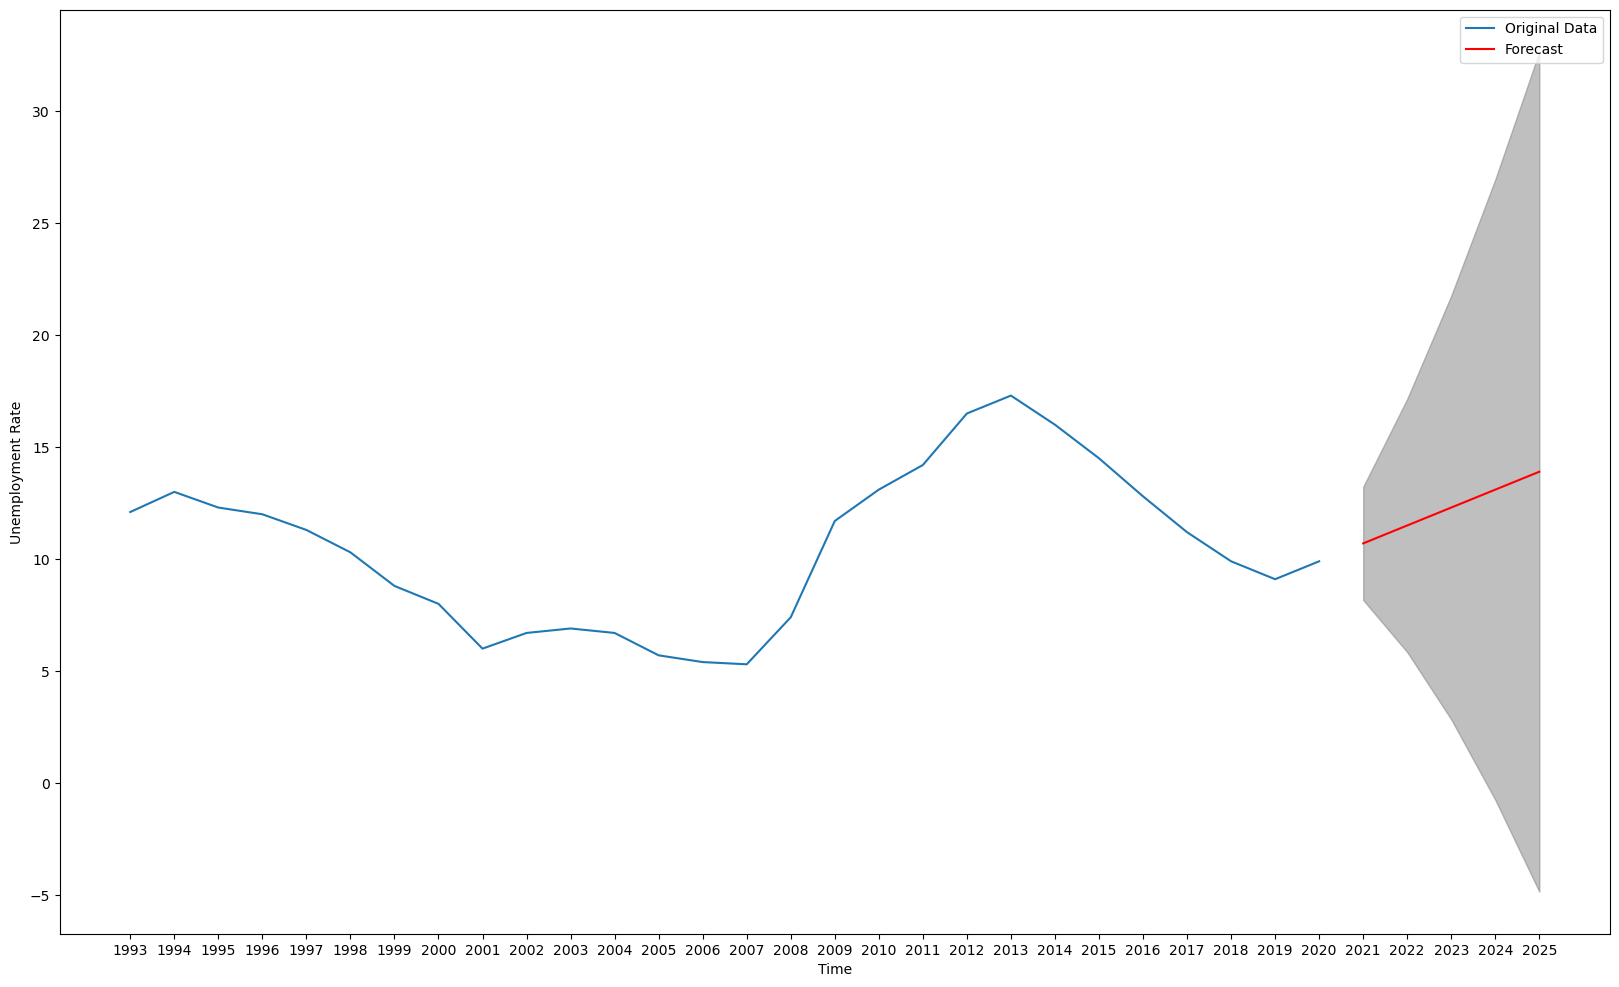

In [138]:
fig = plt.figure(figsize=(20,12))

# original data
plt.plot(range(len(TS_Spain)), TS_Spain, label='Original Data')

# forecasted values
plt.plot(range(len(TS_Spain), len(TS_Spain) + len(forecast)), forecast, label='Forecast', color='r')


#confidence intervals
plt.fill_between(range(len(TS_Spain), len(TS_Spain) + len(forecast)), conf_interval.iloc[:, 0], conf_interval.iloc[:, 1], color='gray', alpha=0.5)

X_Axis = [i for i in range(1993,2026)]
# set x-axis to data index
plt.xticks(range(len(TS_Spain) + 5 ), X_Axis)

# plot settings
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()



## Greece Data

In [139]:
TS_Greece = Unemployment_rate_pivot.loc['GRC']

In [140]:
#!pip install pmdarima



# Fit an auto_arima model
auto_arima_model = auto_arima(TS_Greece, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the best parameters
print("Best Parameters: ", auto_arima_model.order)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=63.617, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=68.077, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=66.377, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=62.142, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=66.123, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=63.540, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=60.149, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=61.629, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=61.555, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=64.387, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.582 seconds
Best Parameters:  (0, 2, 1)


the ARIMA(0,2,1) model is a model that is based on the second differences of the series, and also considers the past forecast errors with exponential weighting.

In [141]:
# Fit the model
model = sm.tsa.ARIMA(TS_Greece, order=(0,2,1))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(TS_Greece), end=len(TS_Greece)+5)


# Make predictions
forecast_object = model_fit.get_forecast(steps = 5)
conf_interval = forecast_object.conf_int(alpha=0.05)
forecast = model_fit.forecast(steps=5)

c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


### Plot Of the Time Series

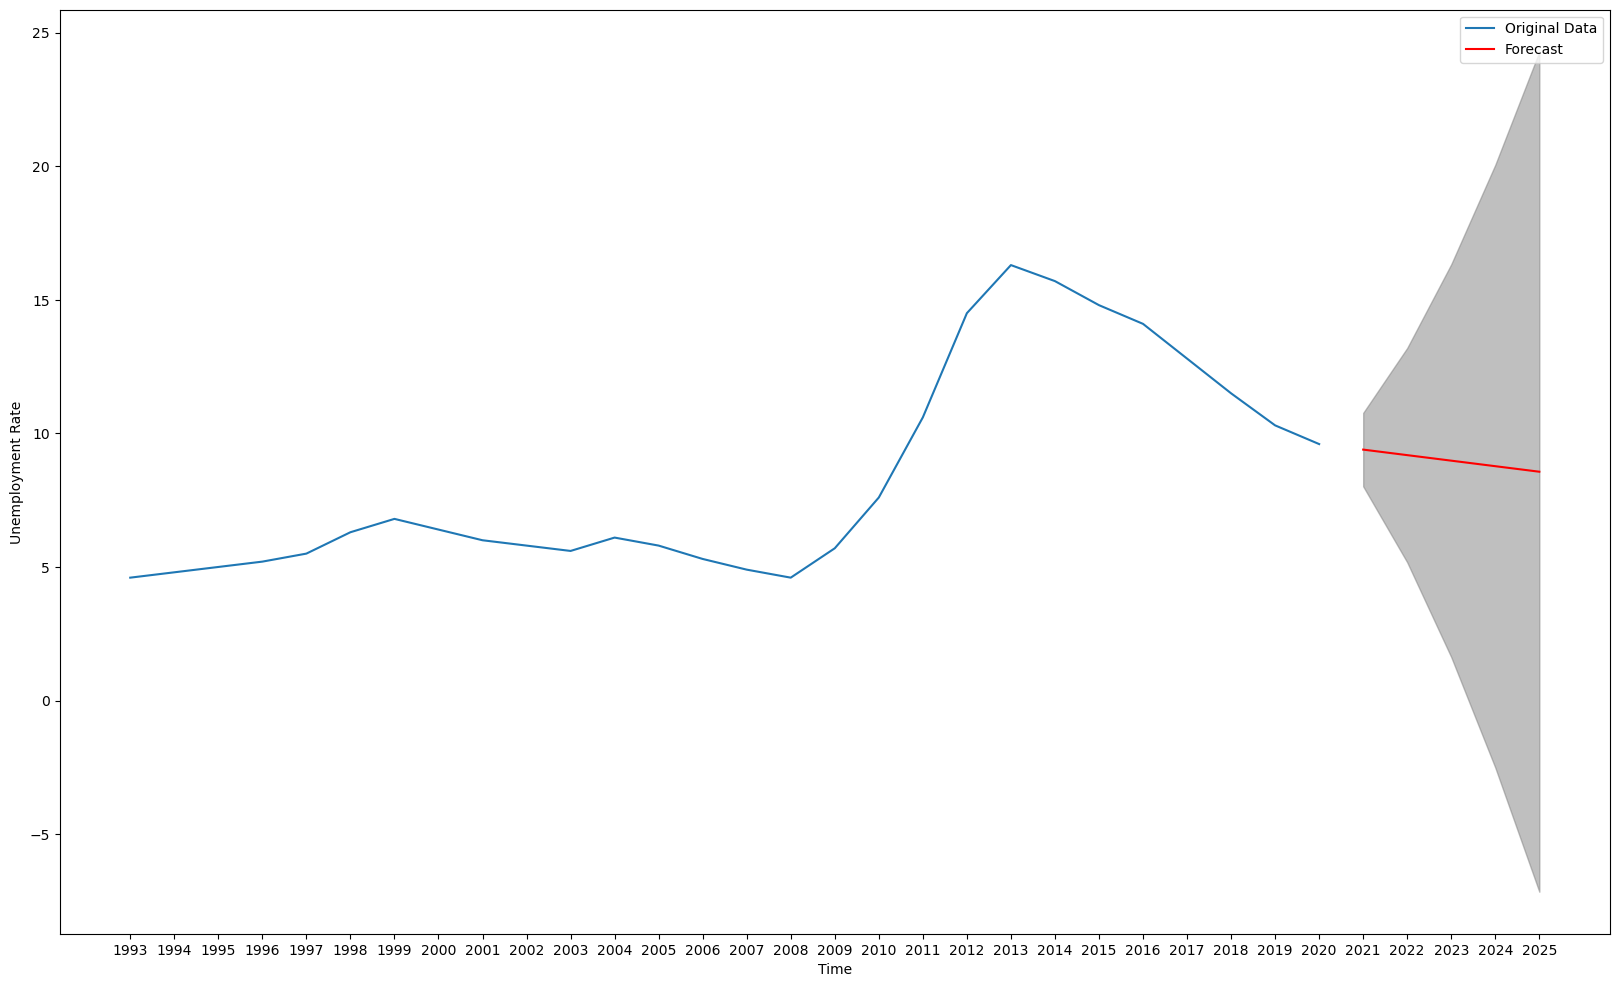

In [142]:
fig = plt.figure(figsize=(20,12))

# original data
plt.plot(range(len(TS_Greece)), TS_Greece, label='Original Data')

# forecasted values
plt.plot(range(len(TS_Greece), len(TS_Greece) + len(forecast)), forecast, label='Forecast', color='r')


#confidence intervals
plt.fill_between(range(len(TS_Greece), len(TS_Greece) + len(forecast)), conf_interval.iloc[:, 0], conf_interval.iloc[:, 1], color='gray', alpha=0.5)

X_Axis = [i for i in range(1993,2026)]
# set x-axis to data index
plt.xticks(range(len(TS_Greece) + 5 ), X_Axis)

# plot settings
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()



## Slovakia Data

In [143]:
TS_Slovakia = Unemployment_rate_pivot.loc['SVK'].iloc[4:]
TS_Slovakia

TIME
1997     7.7
1998     7.9
1999    10.3
2000    11.9
2001    12.4
2002    11.9
2003    11.2
2004    11.6
2005    10.3
2006     8.4
2007     7.0
2008     6.0
2009     7.5
2010     9.0
2011     8.5
2012     8.8
2013     9.0
2014     8.4
2015     7.3
2016     6.2
2017     5.2
2018     4.2
2019     3.7
2020     4.3
Name: SVK, dtype: float64

In [144]:


#!pip install pmdarima



# Fit an auto_arima model
auto_arima_model = auto_arima(TS_Slovakia, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the best parameters
print("Best Parameters: ", auto_arima_model.order)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=69.984, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=71.979, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=71.961, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=67.990, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.348 seconds
Best Parameters:  (0, 2, 0)


In [145]:
# Fit the model
model = sm.tsa.ARIMA(TS_Slovakia, order=(0,2,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(TS_Slovakia), end=len(TS_Slovakia)+5)


# Make predictions
forecast_object = model_fit.get_forecast(steps = 5)
conf_interval = forecast_object.conf_int(alpha=0.05)
forecast = model_fit.forecast(steps=5)

c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\SAMI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


### Plot of the Time Series

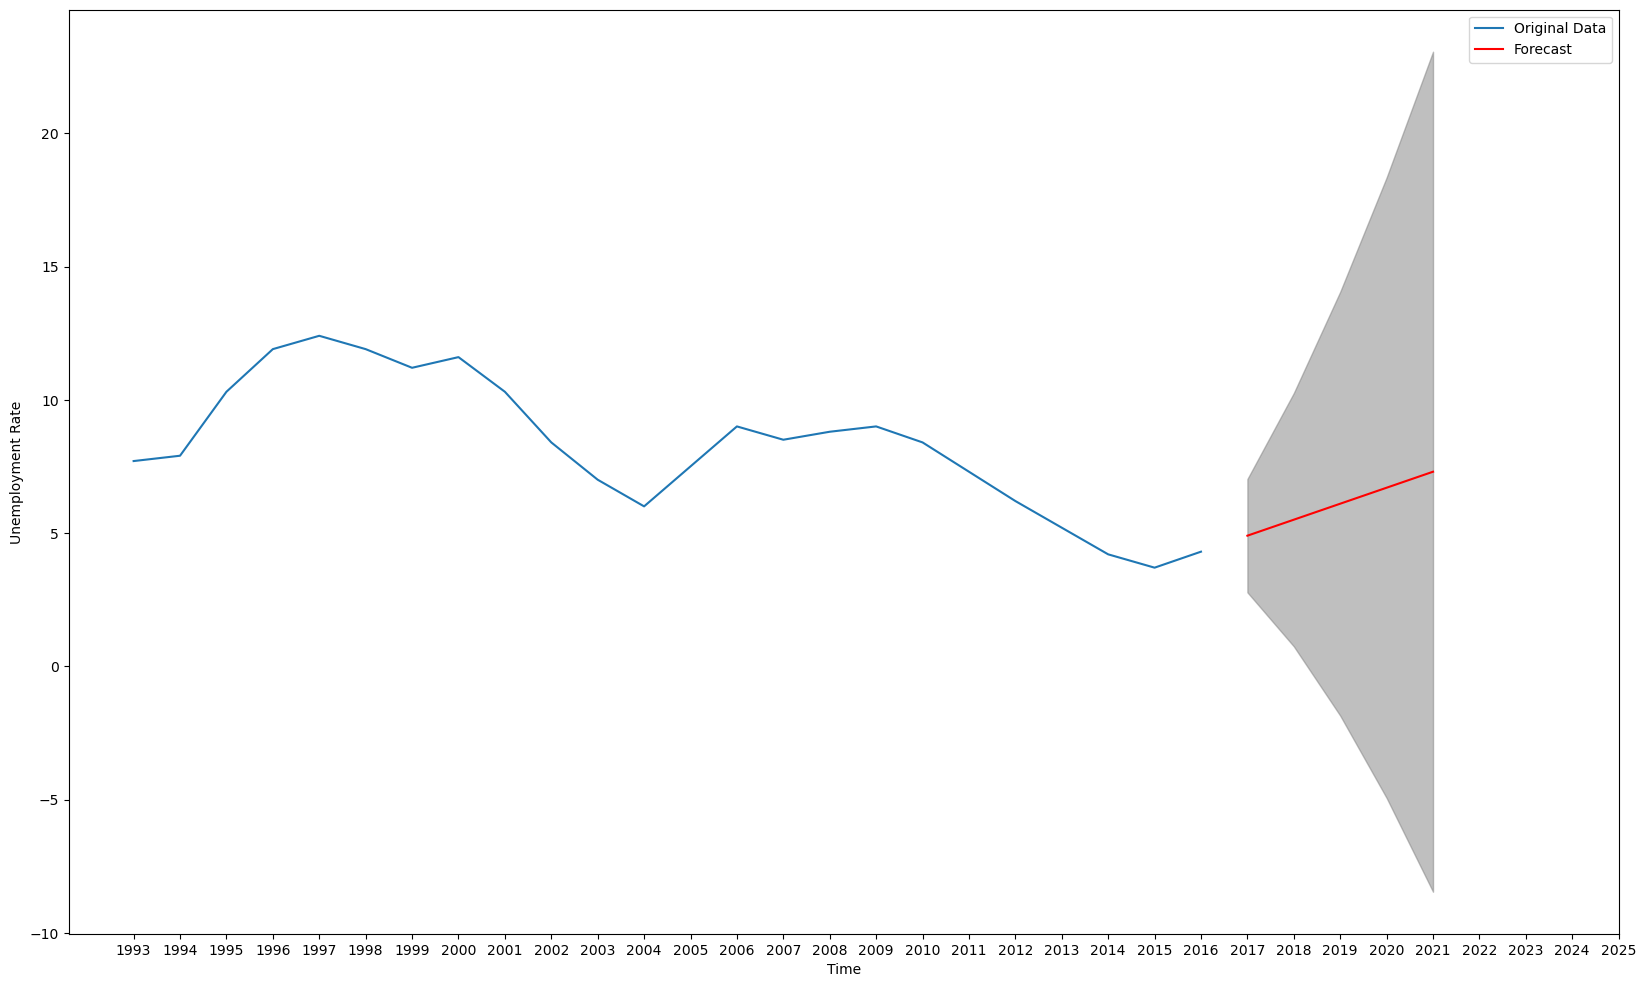

In [148]:
fig = plt.figure(figsize=(20,12))

# original data
plt.plot(range(len(TS_Slovakia)), TS_Slovakia, label='Original Data')

# forecasted values
plt.plot(range(len(TS_Slovakia), len(TS_Slovakia) + len(forecast)), forecast, label='Forecast', color='r')


#confidence intervals
plt.fill_between(range(len(TS_Slovakia), len(TS_Slovakia) + len(forecast)), conf_interval.iloc[:, 0], conf_interval.iloc[:, 1], color='gray', alpha=0.5)

X_Axis = [i for i in range(1993,2026)]
# set x-axis to data index
plt.xticks(range(len(TS_Slovakia) + 9 ), X_Axis)

# plot settings
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

